# This script creates visualizations for the ML model we created in the script 'brick_image_classifier.ipynb'

In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
import random
from tqdm import tqdm
from tensorflow import keras
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
from PIL import ImageFile                            
import pickle
import keract
from keract import get_activations, display_heatmaps, display_activations

# Load Images From File

In [2]:
image_names = [item.replace('resources/data_for_training_06/', '') for item in sorted(glob("resources/data_for_training_06/*/"))]
number_of_image_categories = len(image_names)
print('%d image categories.' % number_of_image_categories)
print('Three categories:')
print(image_names[:3])

3 image categories.
Three categories:
['brick_10/', 'siding_20/', 'unknown_00/']


# Define Function for Validation, Test and Target images

In [3]:
def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), number_of_image_categories)
    return image_files, image_targets


image_files, image_targets = load_dataset('resources/data_for_training_06/')

trains_validate_files, test_files, trains_validate_targets, test_targets = \
    train_test_split(image_files, image_targets, test_size=0.2, random_state=42)

train_files, valid_files, train_targets, valid_targets = \
    train_test_split(trains_validate_files, trains_validate_targets, test_size=0.25, random_state=42)

image_names = [item for item in sorted(glob("resources/data_for_training_06/*/"))]

print('%s images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('%d training images.' % len(train_files))
print('%d validation images.' % len(valid_files))
print('%d test images.'% len(test_files))

4105 images.

2463 training images.
821 validation images.
821 test images.


# Define function for preprocessing images

In [4]:
def path_to_tensor(img_path):

    img = image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(500, 500), interpolation="nearest")
    img_array = image.img_to_array(img)

    return np.expand_dims(img_array, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Preprocess images

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 821/821 [00:11<00:00, 71.07it/s]


# Load Saved Keras model (weights) and history (dict)

In [6]:
model = keras.models.load_model('saved_models/20201117_77pct_weights_classifier.hdf5')
model.load_weights('saved_models/20201117_77pct_weights_classifier.hdf5')

In [7]:
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.1011%


# Load history dictionary from pickle

In [8]:
# OPTIONAL WRITE HISTORY TO JSON

# UNCOMMENT TO SAVE DICT
# with open('saved_models/20201117_77pct_trainHistoryDict', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

model_history = pickle.load(open('saved_models/20201117_77pct_trainHistoryDict', "rb"))


# Built Model Sample for reference

In [9]:
# model = Sequential()
# # ADJUST FILTER?
# model.add(Conv2D(filters=2, kernel_size=2, padding='same',
#                  activation='relu', input_shape=(500, 500, 3)))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters=4, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.3))

# model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.4))


# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.4))

# model.add(Dense(3, activation='softmax'))


# model.summary()

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Check model predictions on a few test images

In [10]:
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (500,500,3))
    predictions = model.predict(np.array([resized_image]))

    if image.split("_")[0] == "brick":
        print(image, predictions)
        
# Quick Key to check accuracy from a few test files
#['brick_10/', 'siding_20/', 'unknown_00/']

brick_7266.jpg [[0.82667154 0.0771282  0.09620021]]
brick_81.jpg [[0.5450016  0.32321116 0.13178727]]
brick_7664.jpg [[0.49038166 0.18048723 0.32913116]]
brick_5901.jpg [[0.52464265 0.26149926 0.2138581 ]]
brick_62.jpg [[0.7463111  0.1117188  0.14197002]]
brick_7839.jpg [[0.56834656 0.16927946 0.26237404]]
brick_6449.jpg [[0.35541376 0.31256264 0.33202356]]


# Load sample image to manually check accuracy

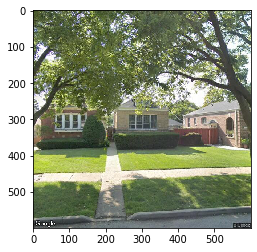

In [11]:
new_image = plt.imread('test_imgs/brick_6449.jpg')
img = plt.imshow(new_image)

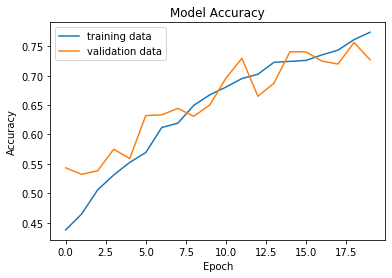

In [12]:
#Visualize the model's accuracy
plt.plot(model_history['accuracy'])
plt.plot(model_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

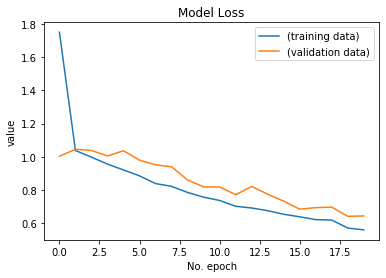

In [13]:
# Plot history: 
plt.plot(model_history['loss'], label='(training data)')
plt.plot(model_history['val_loss'], label='(validation data)')
plt.title('Model Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.savefig('model_loss.png')
plt.show()

# Visualize Model with Keract

conv2d_input (1, 500, 500, 3) 


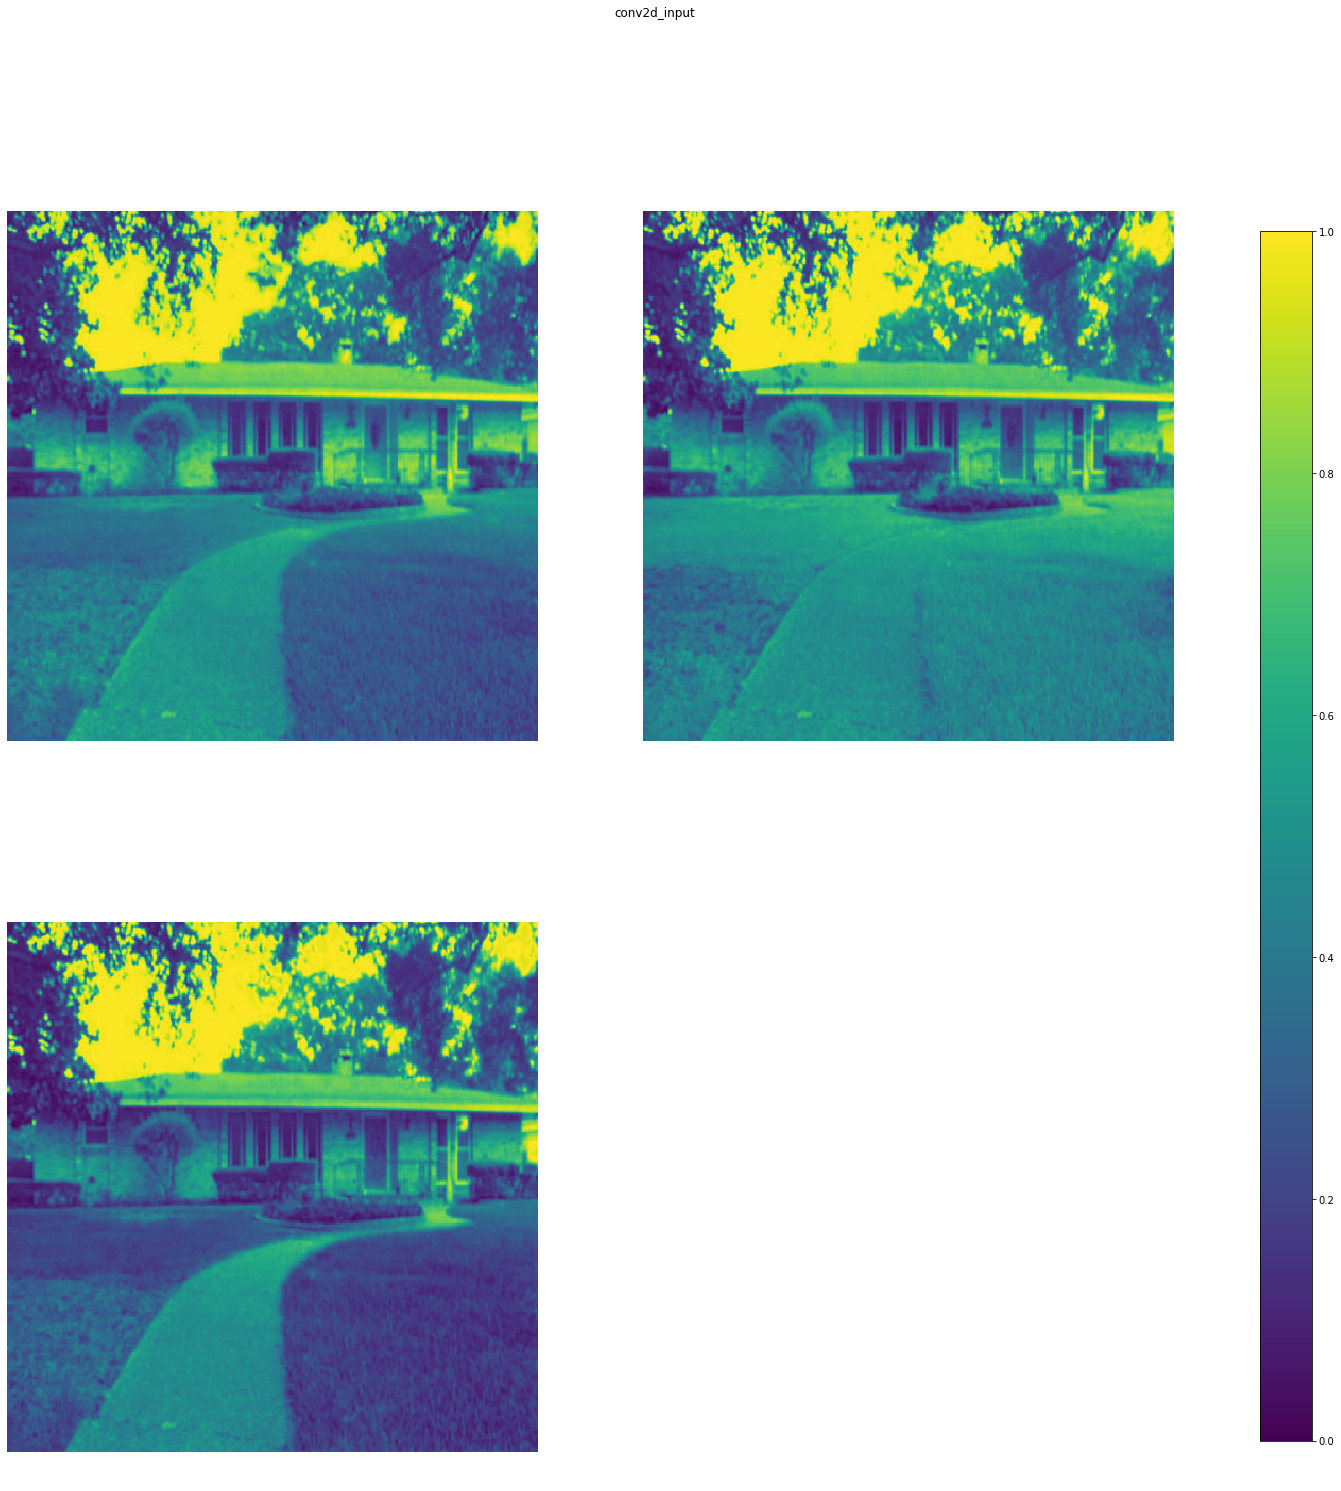

conv2d (1, 500, 500, 2) 


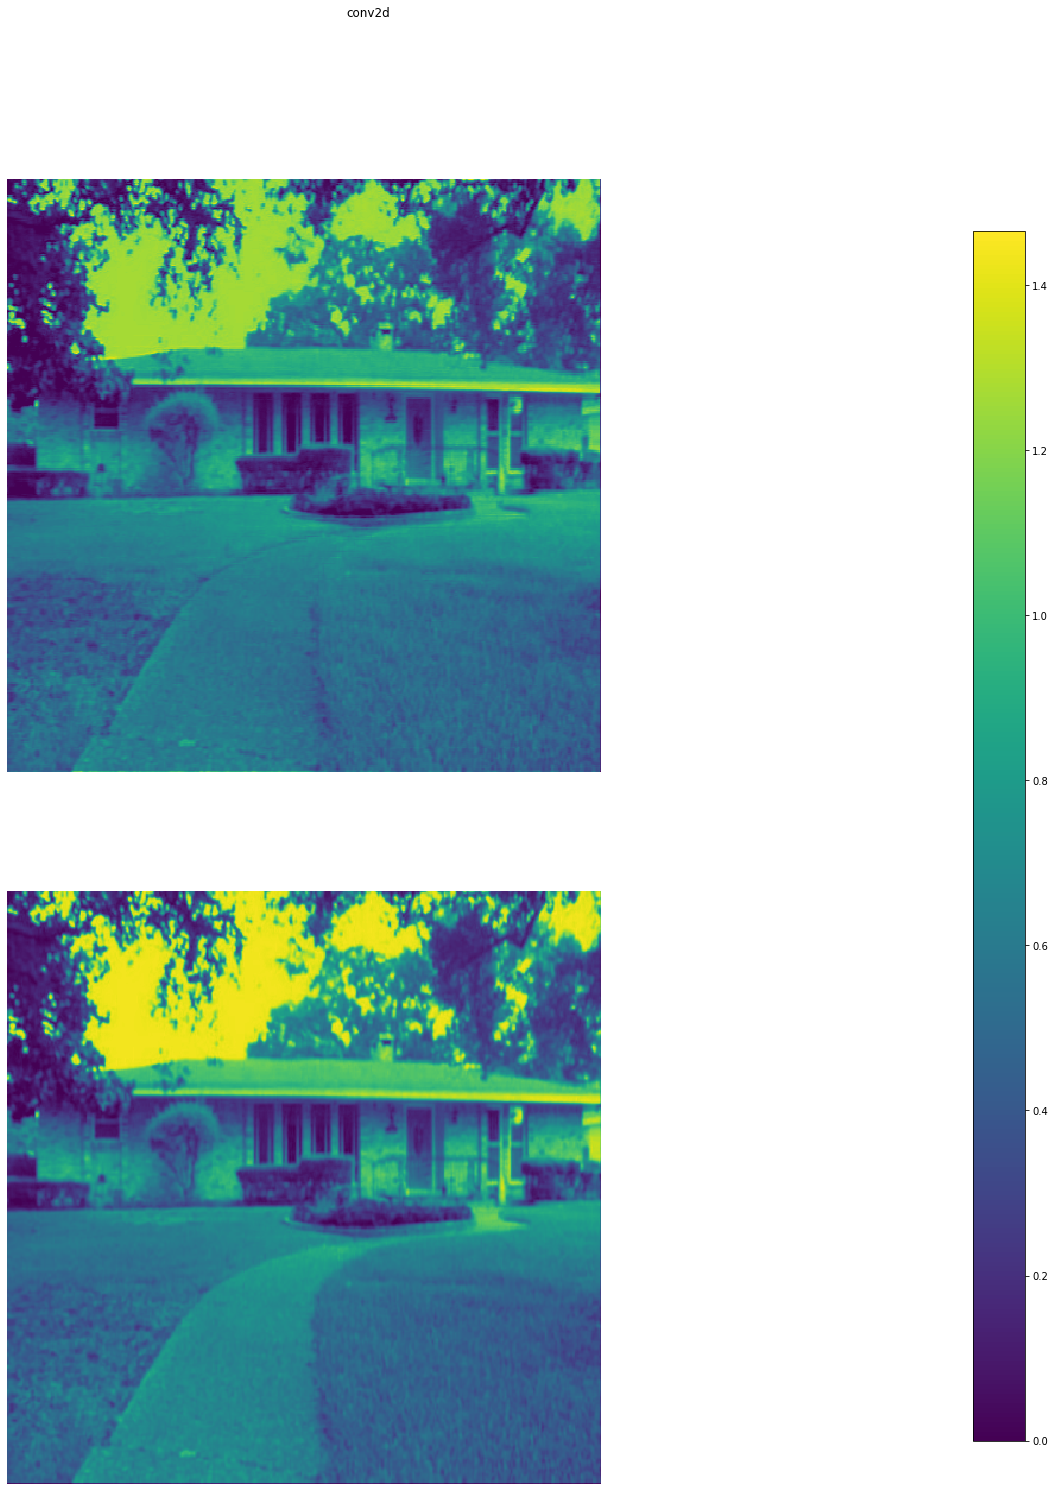

max_pooling2d (1, 250, 250, 2) 


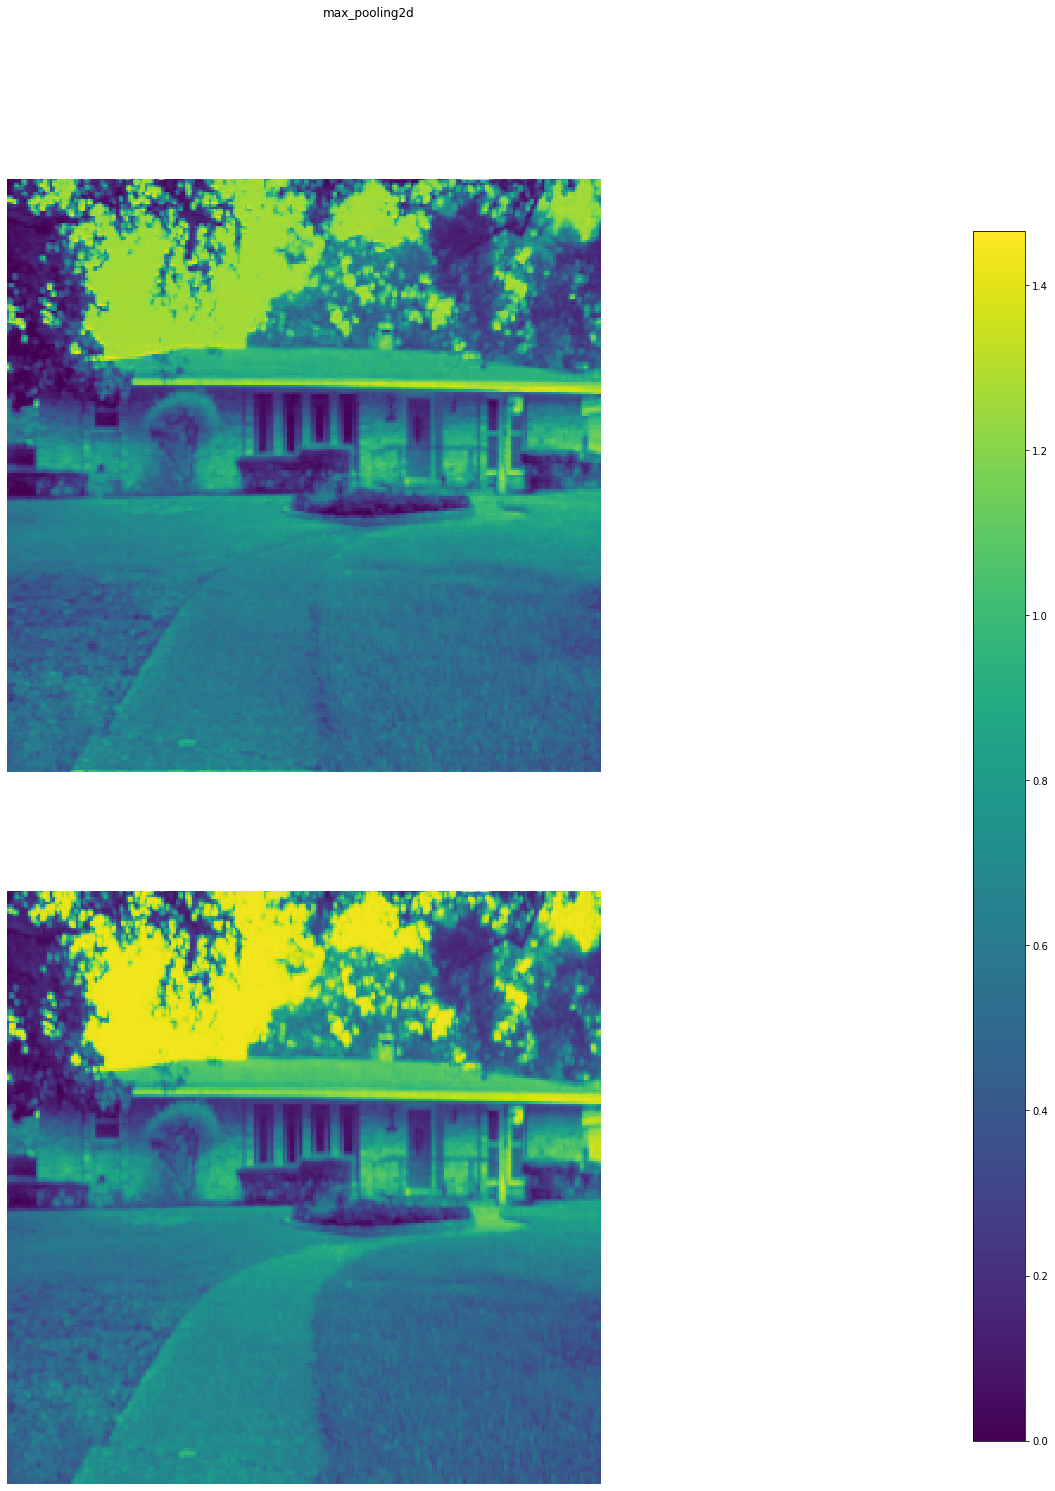

conv2d_1 (1, 250, 250, 4) 


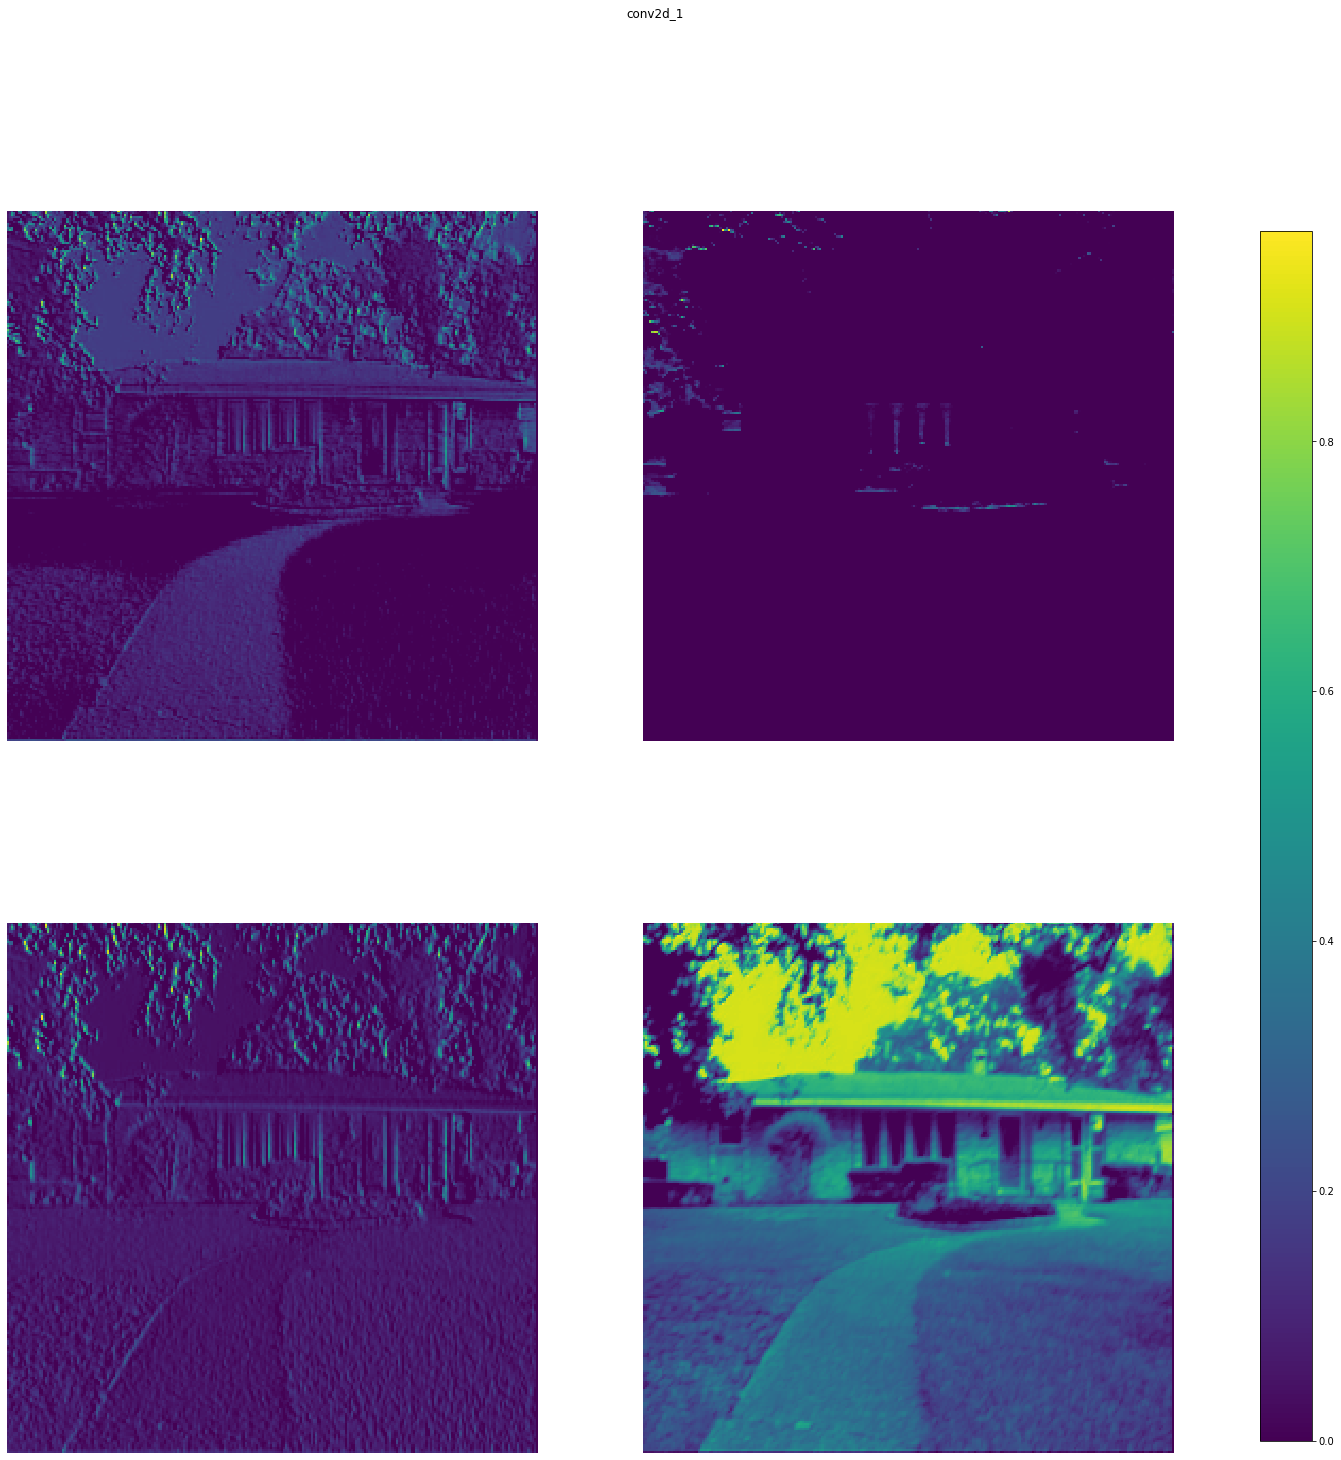

max_pooling2d_1 (1, 125, 125, 4) 


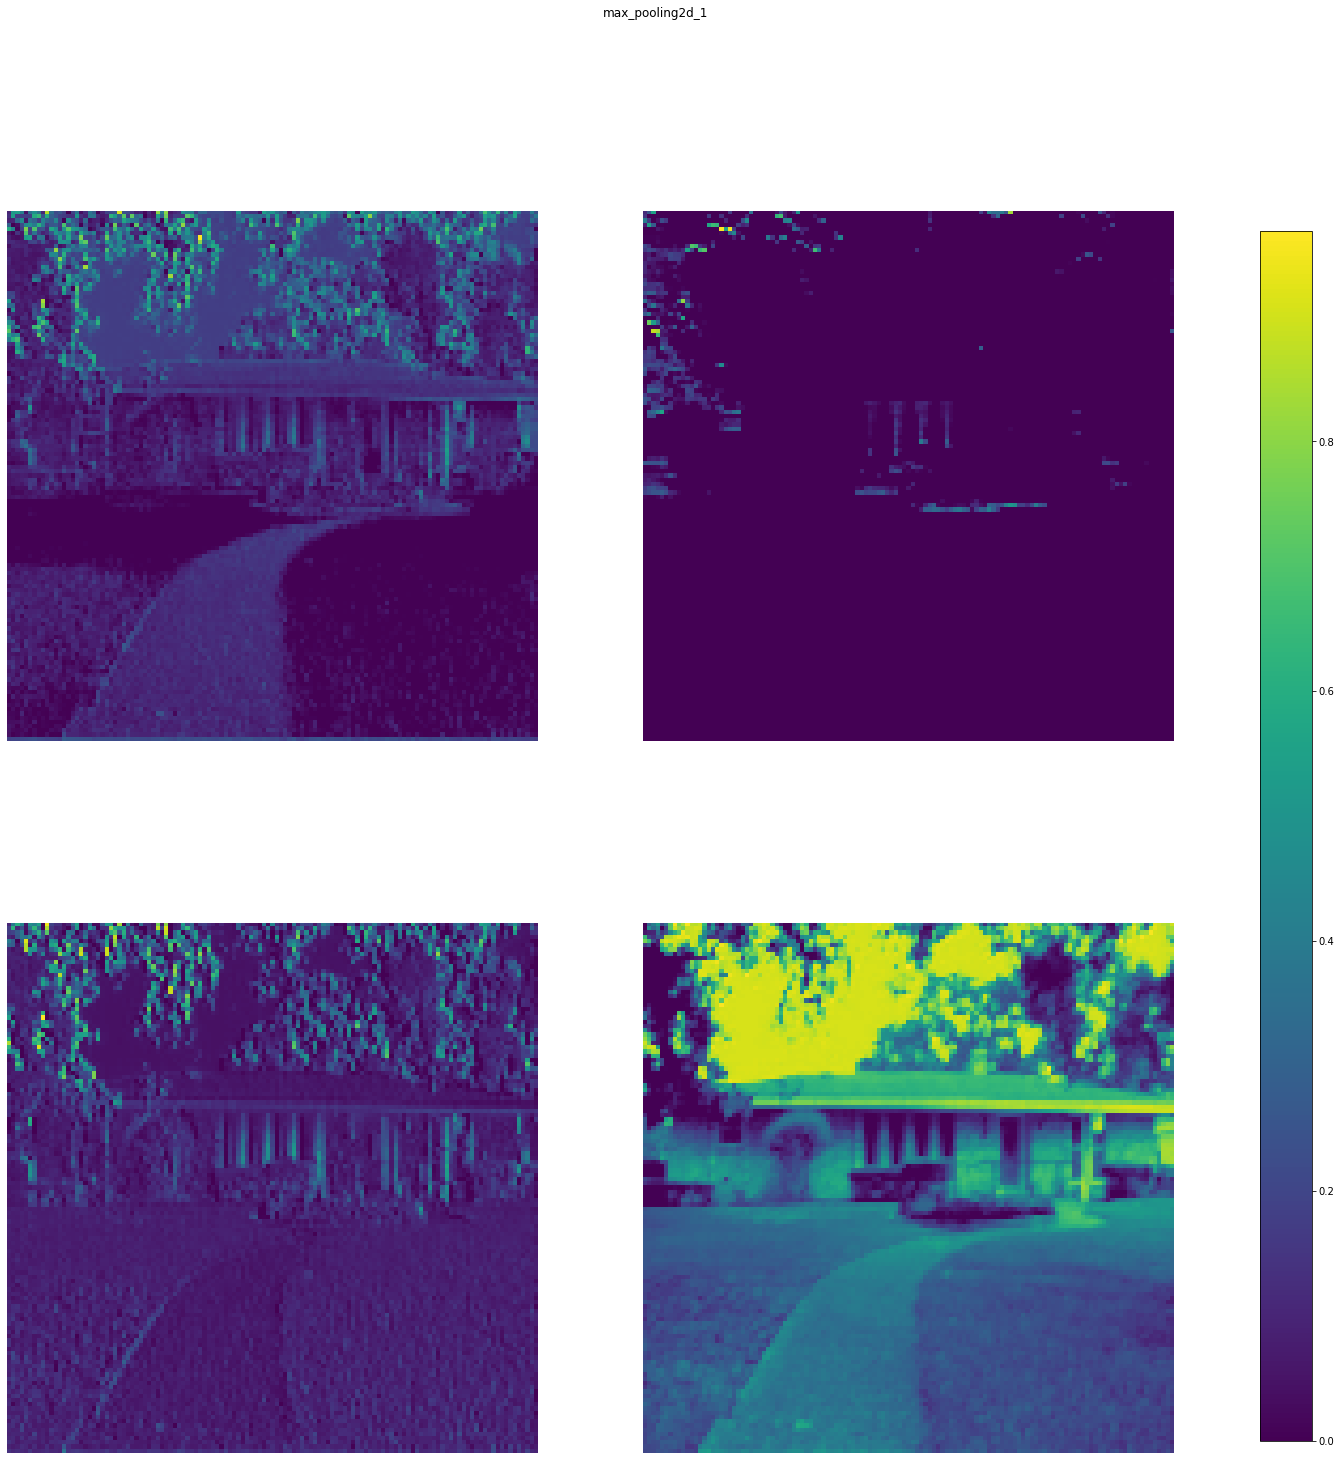

dropout (1, 125, 125, 4) 


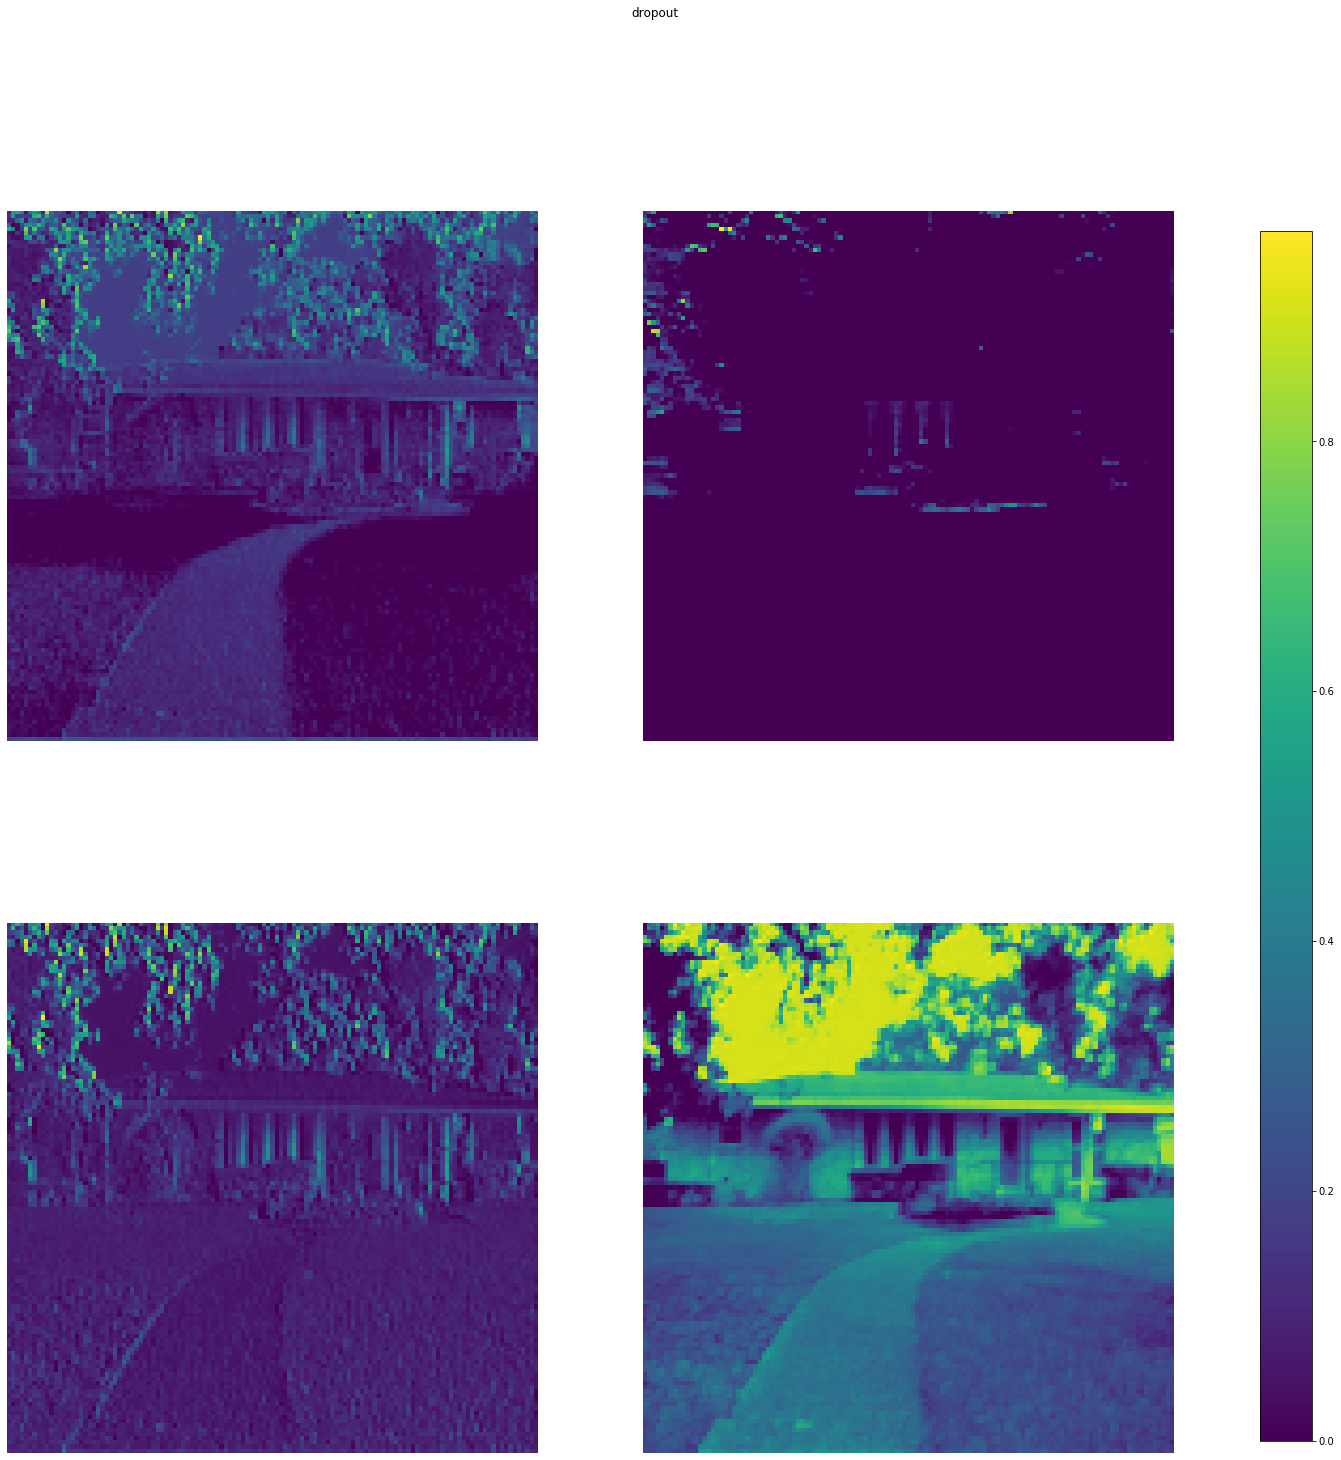

conv2d_2 (1, 125, 125, 8) 


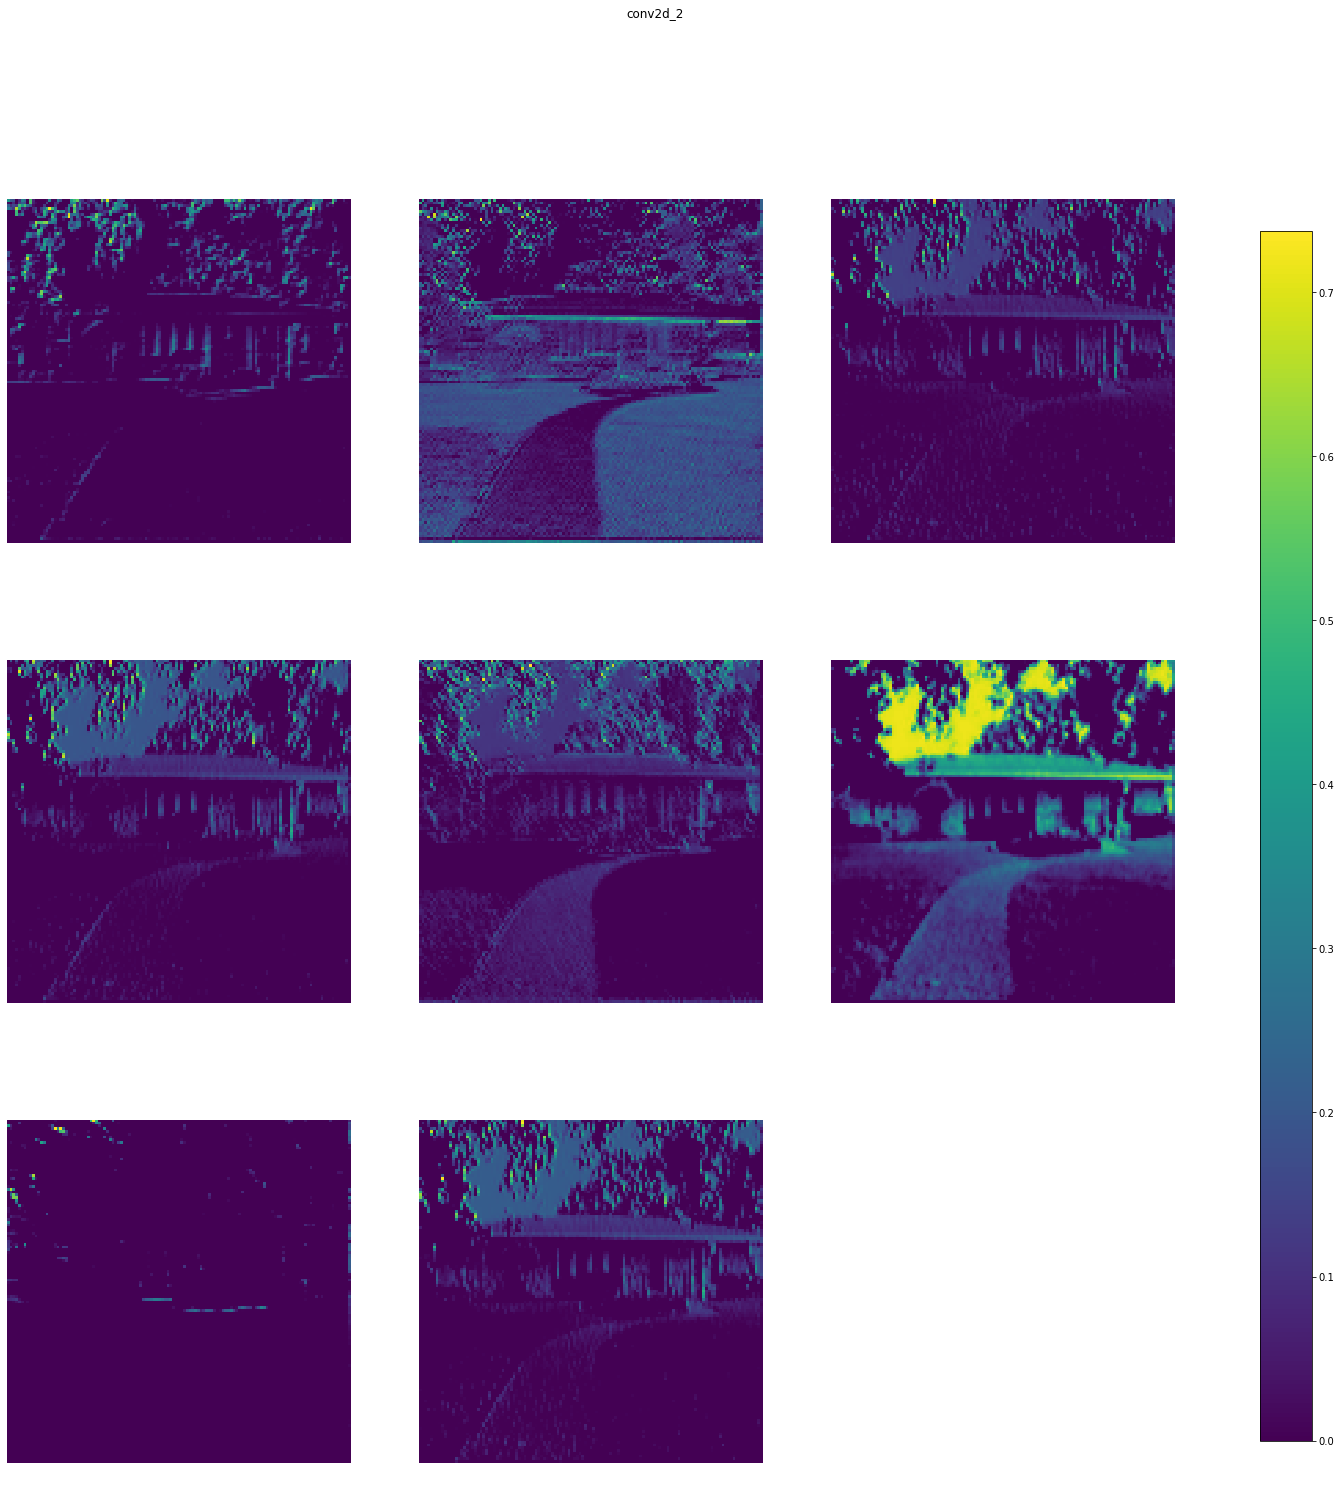

max_pooling2d_2 (1, 62, 62, 8) 


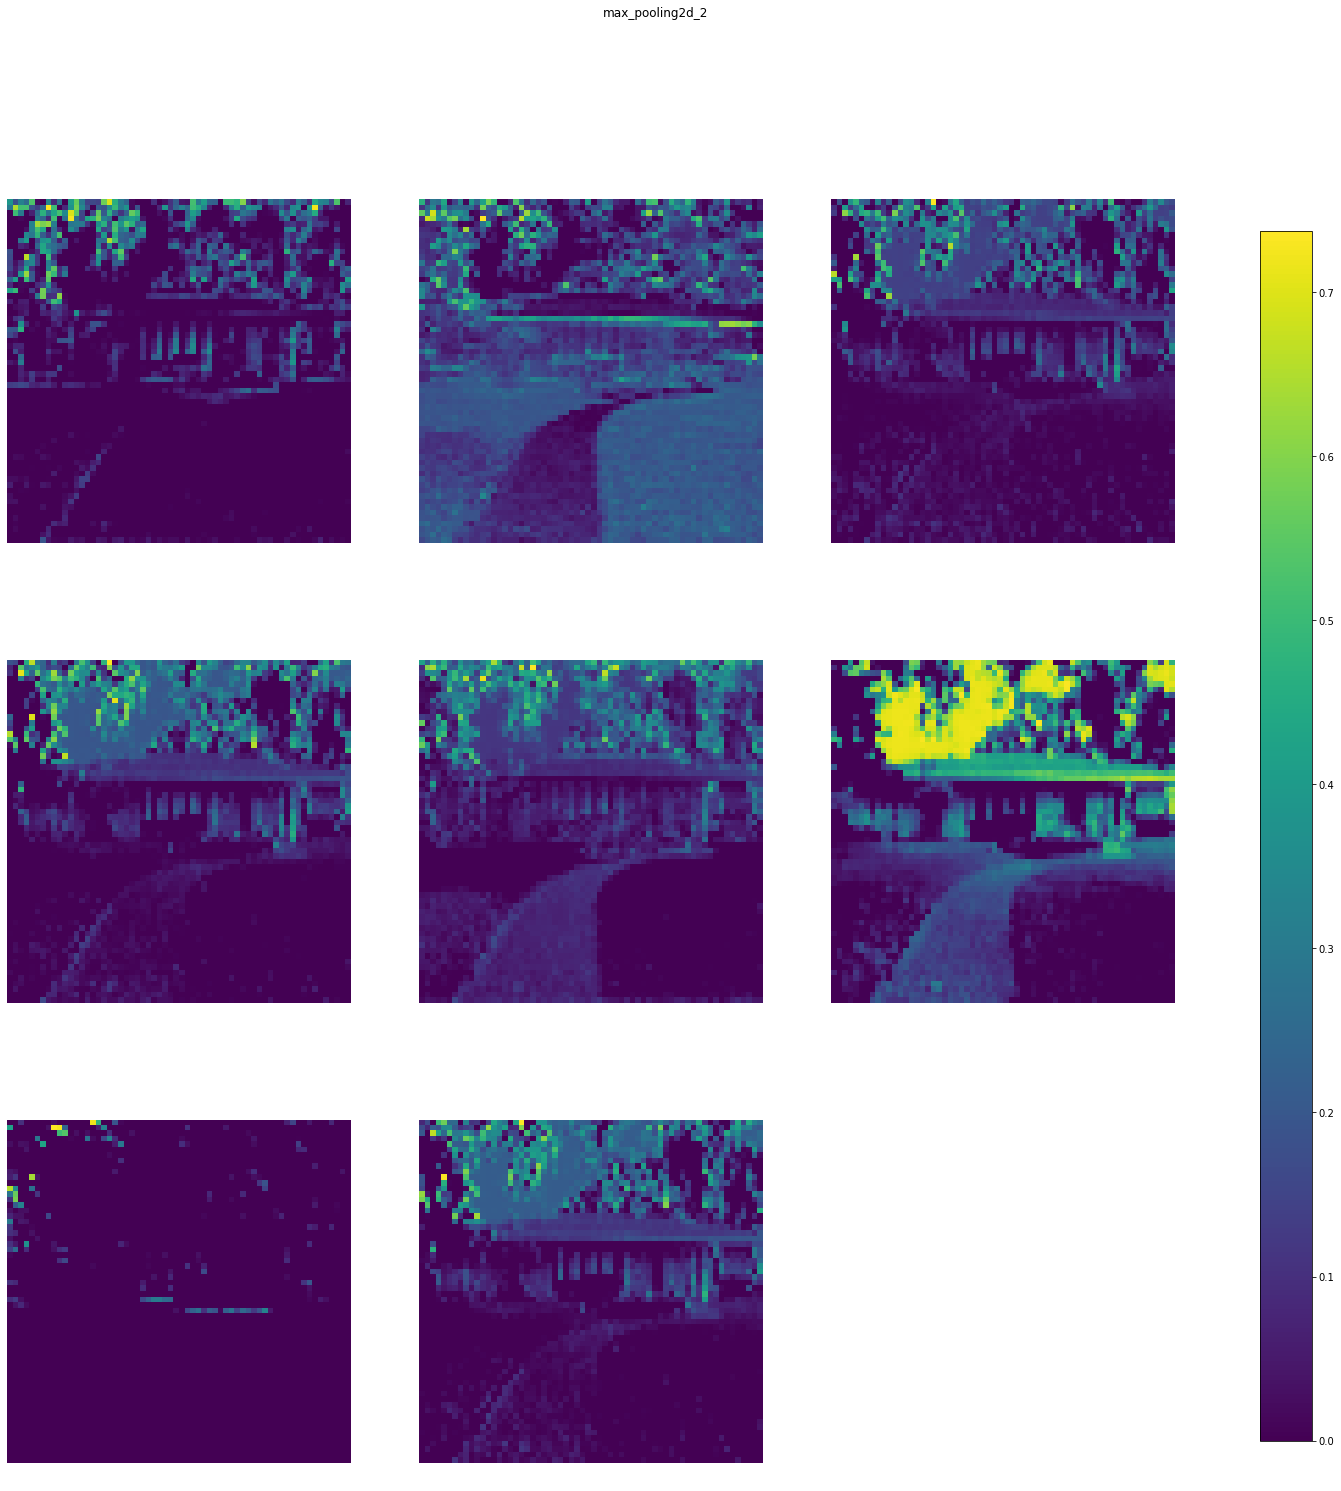

dropout_1 (1, 62, 62, 8) 


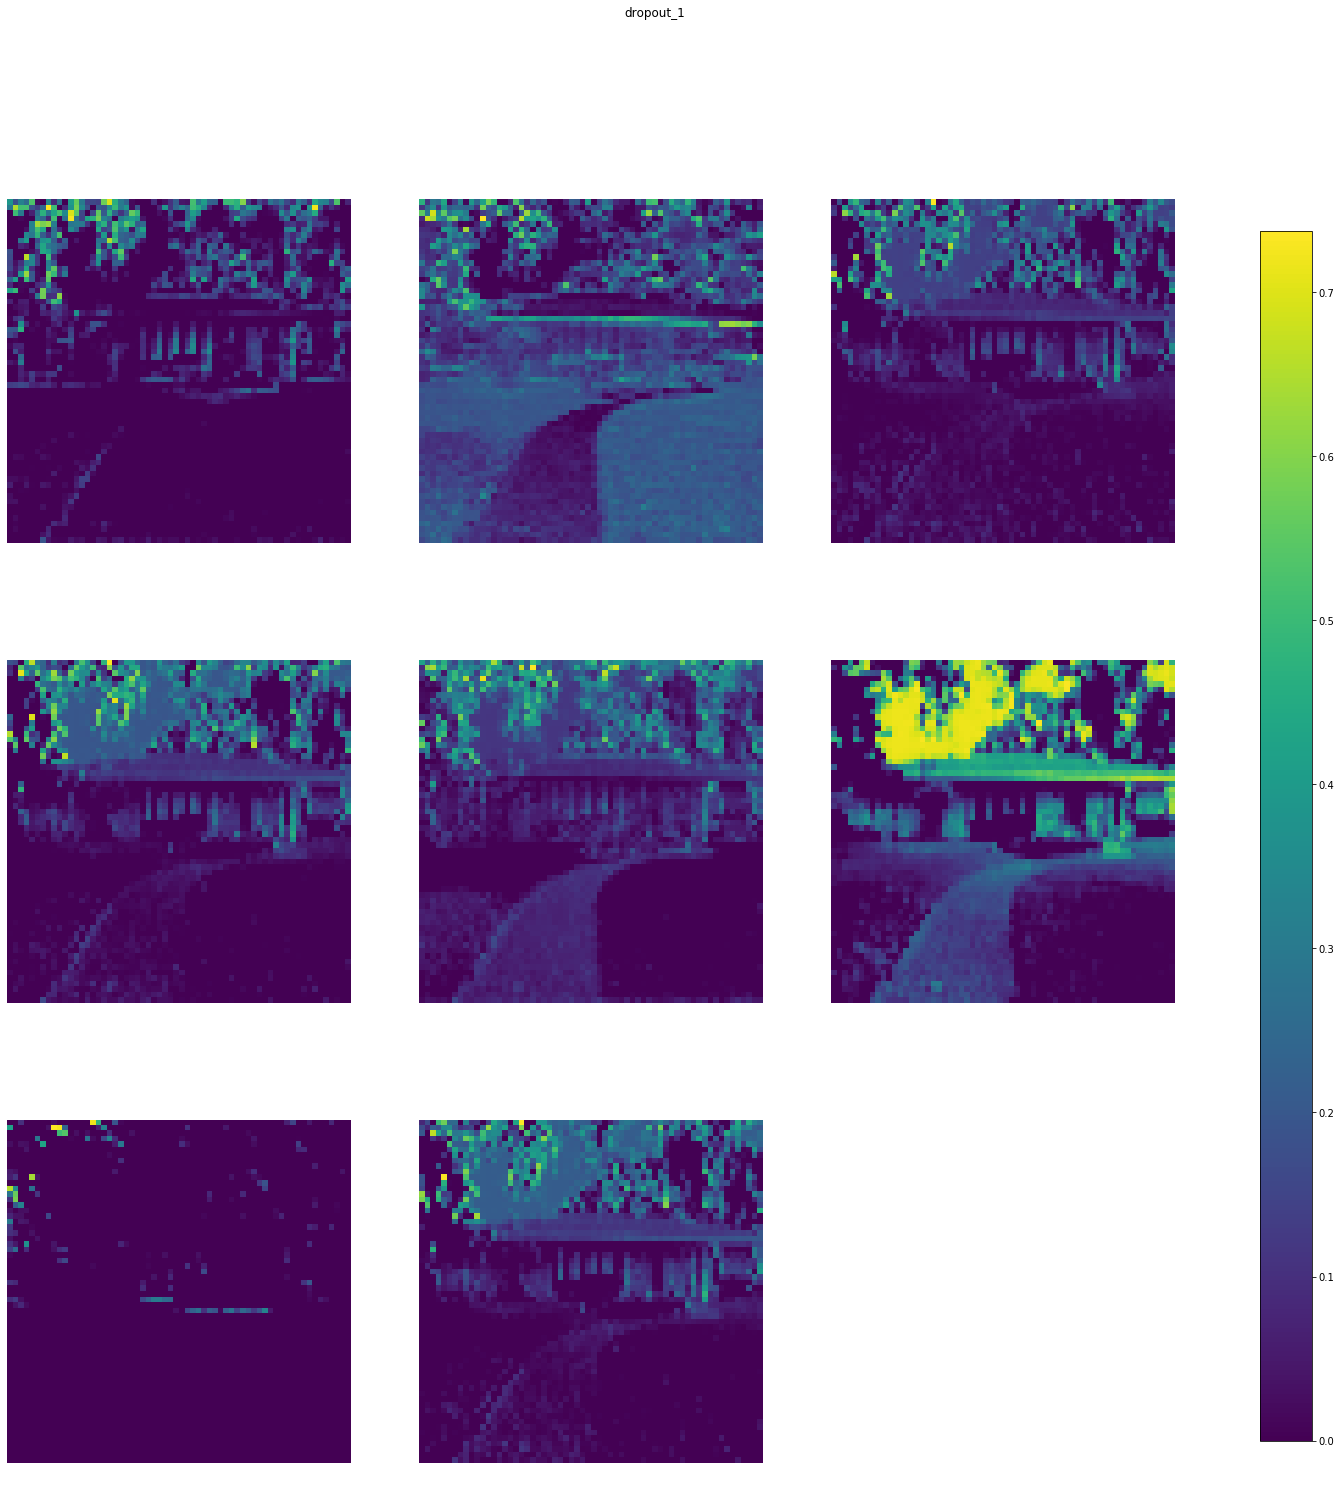

conv2d_3 (1, 62, 62, 12) 


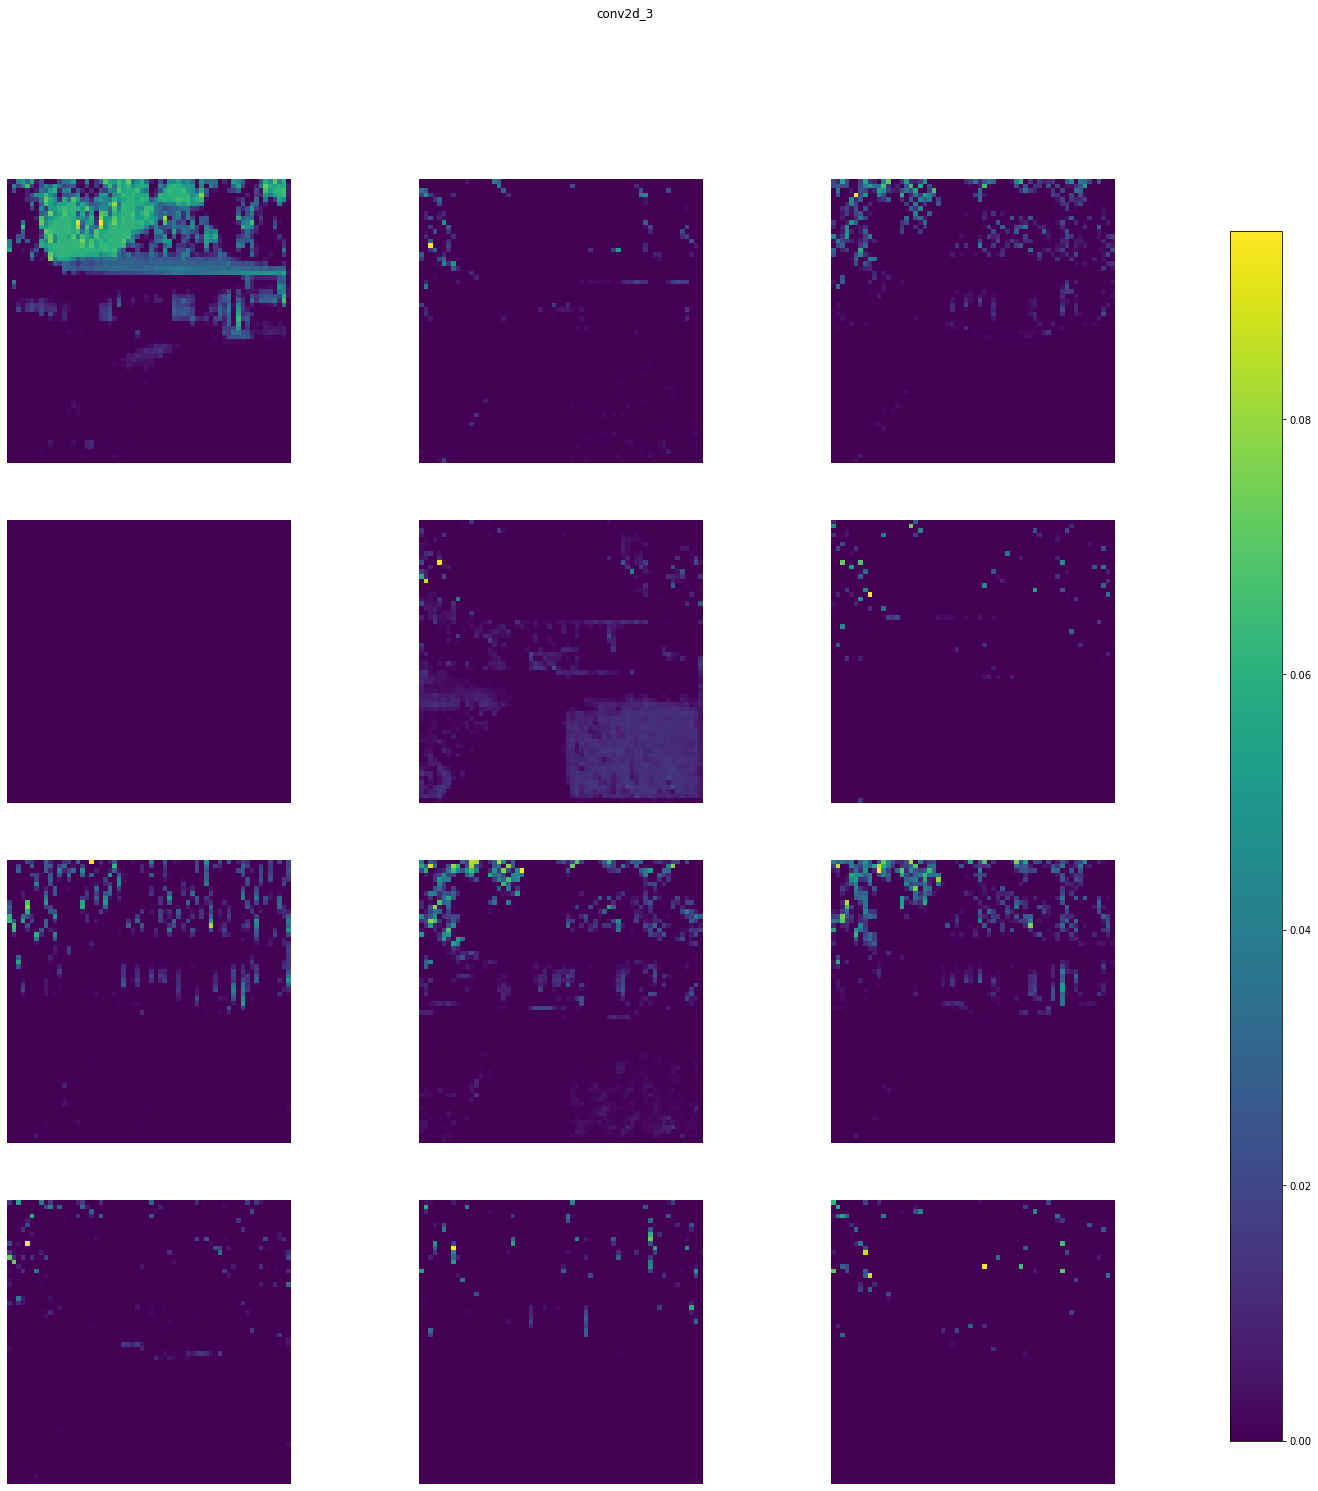

max_pooling2d_3 (1, 31, 31, 12) 


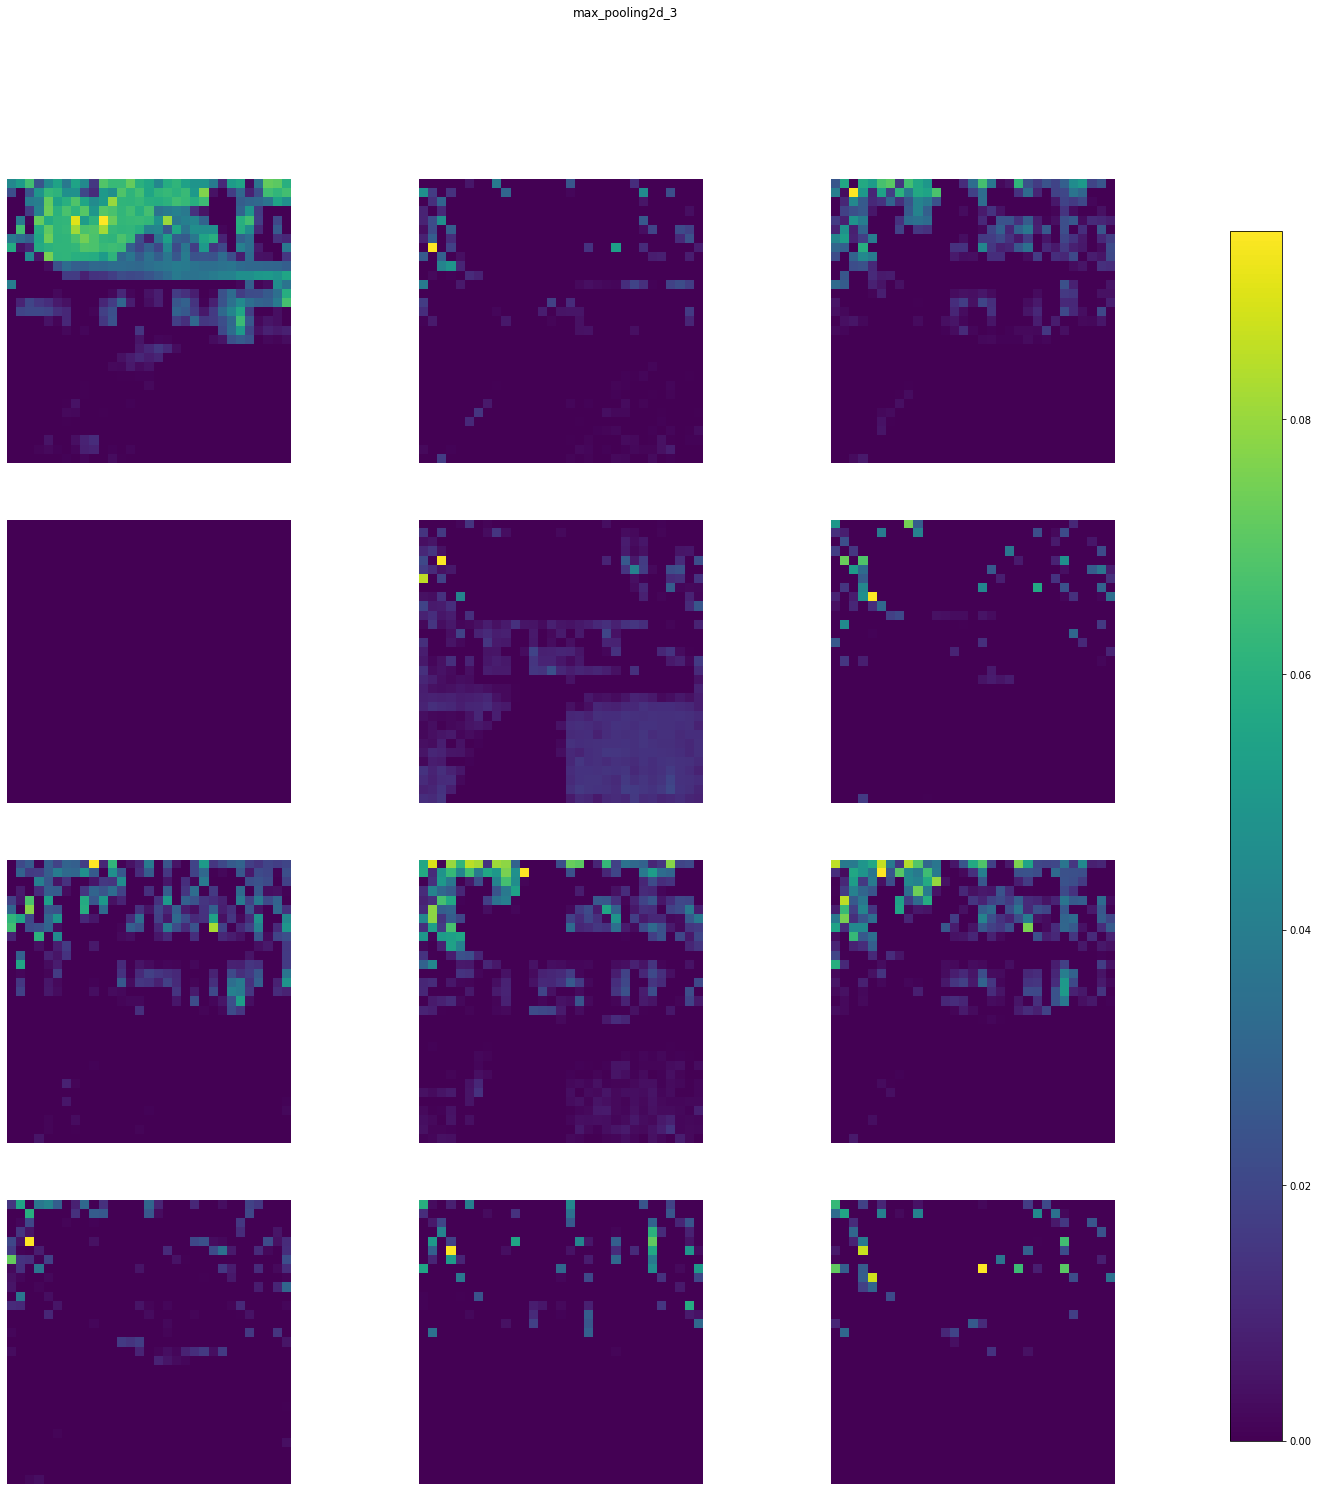

dropout_2 (1, 31, 31, 12) 


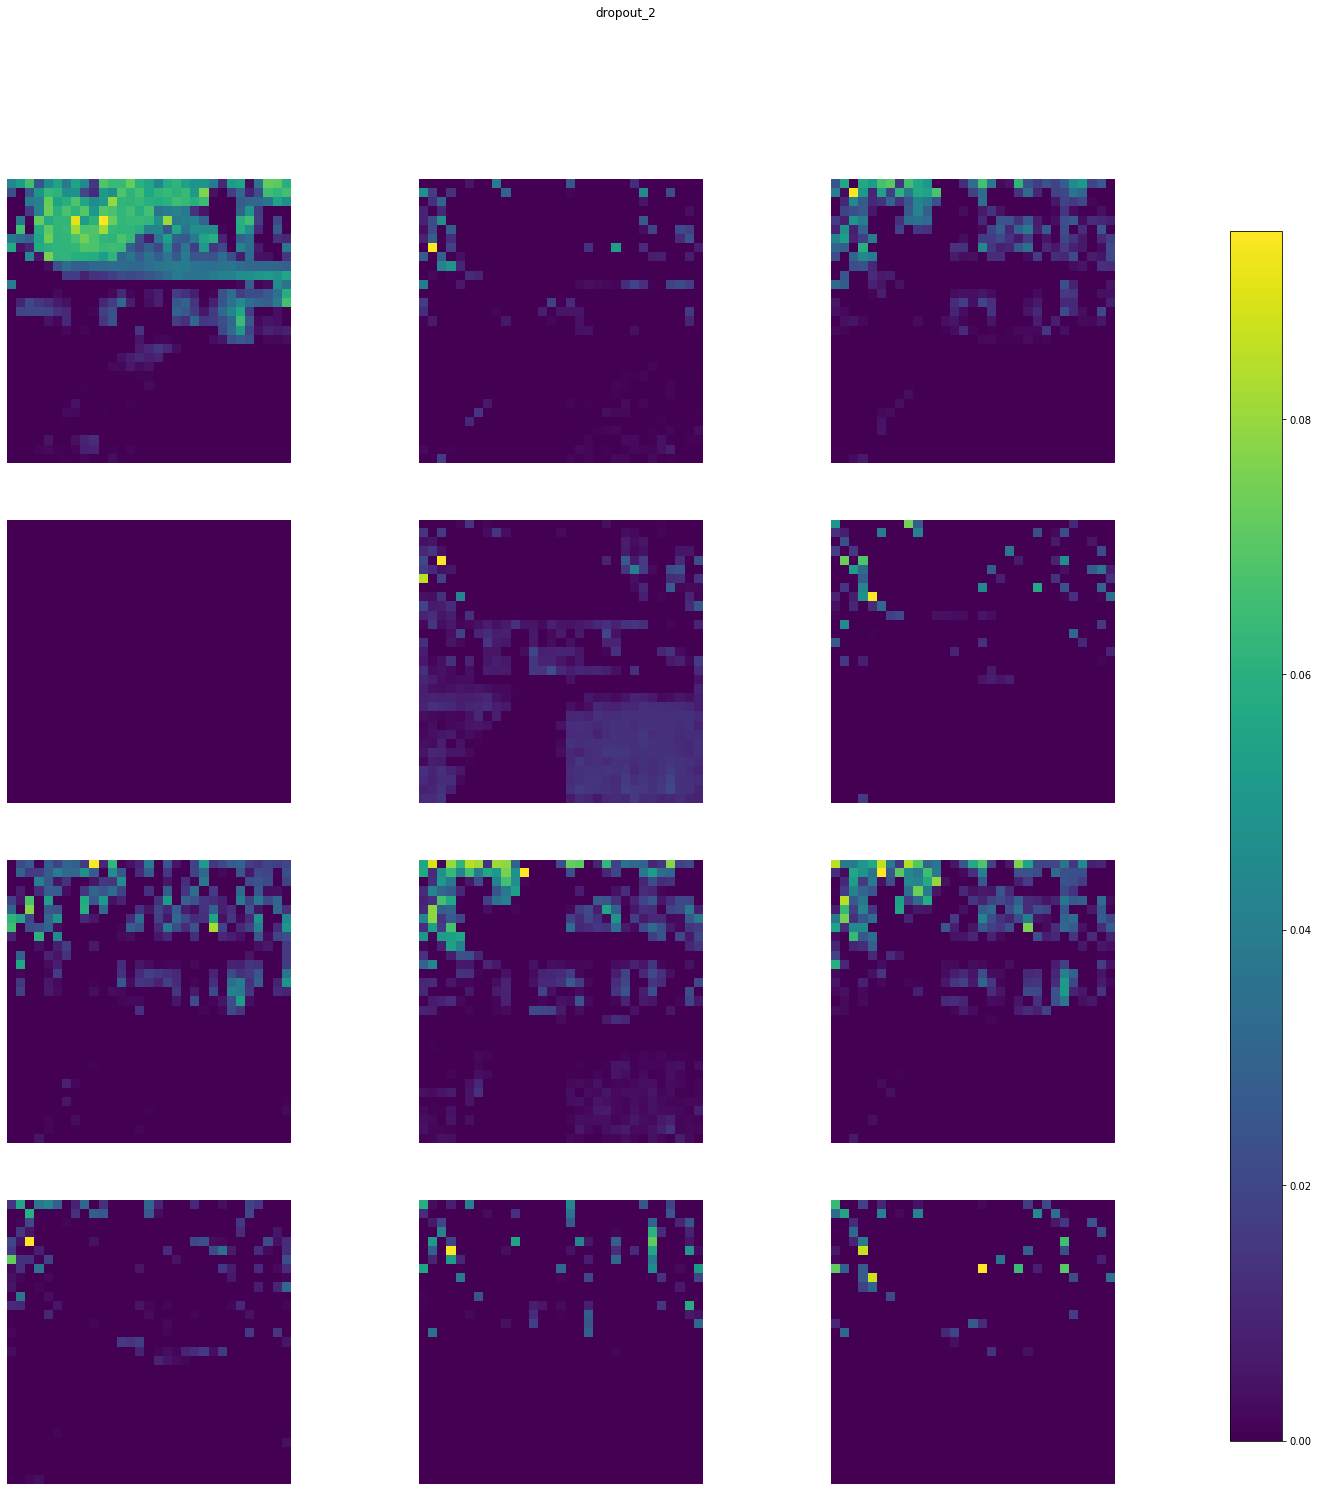

conv2d_4 (1, 31, 31, 16) 


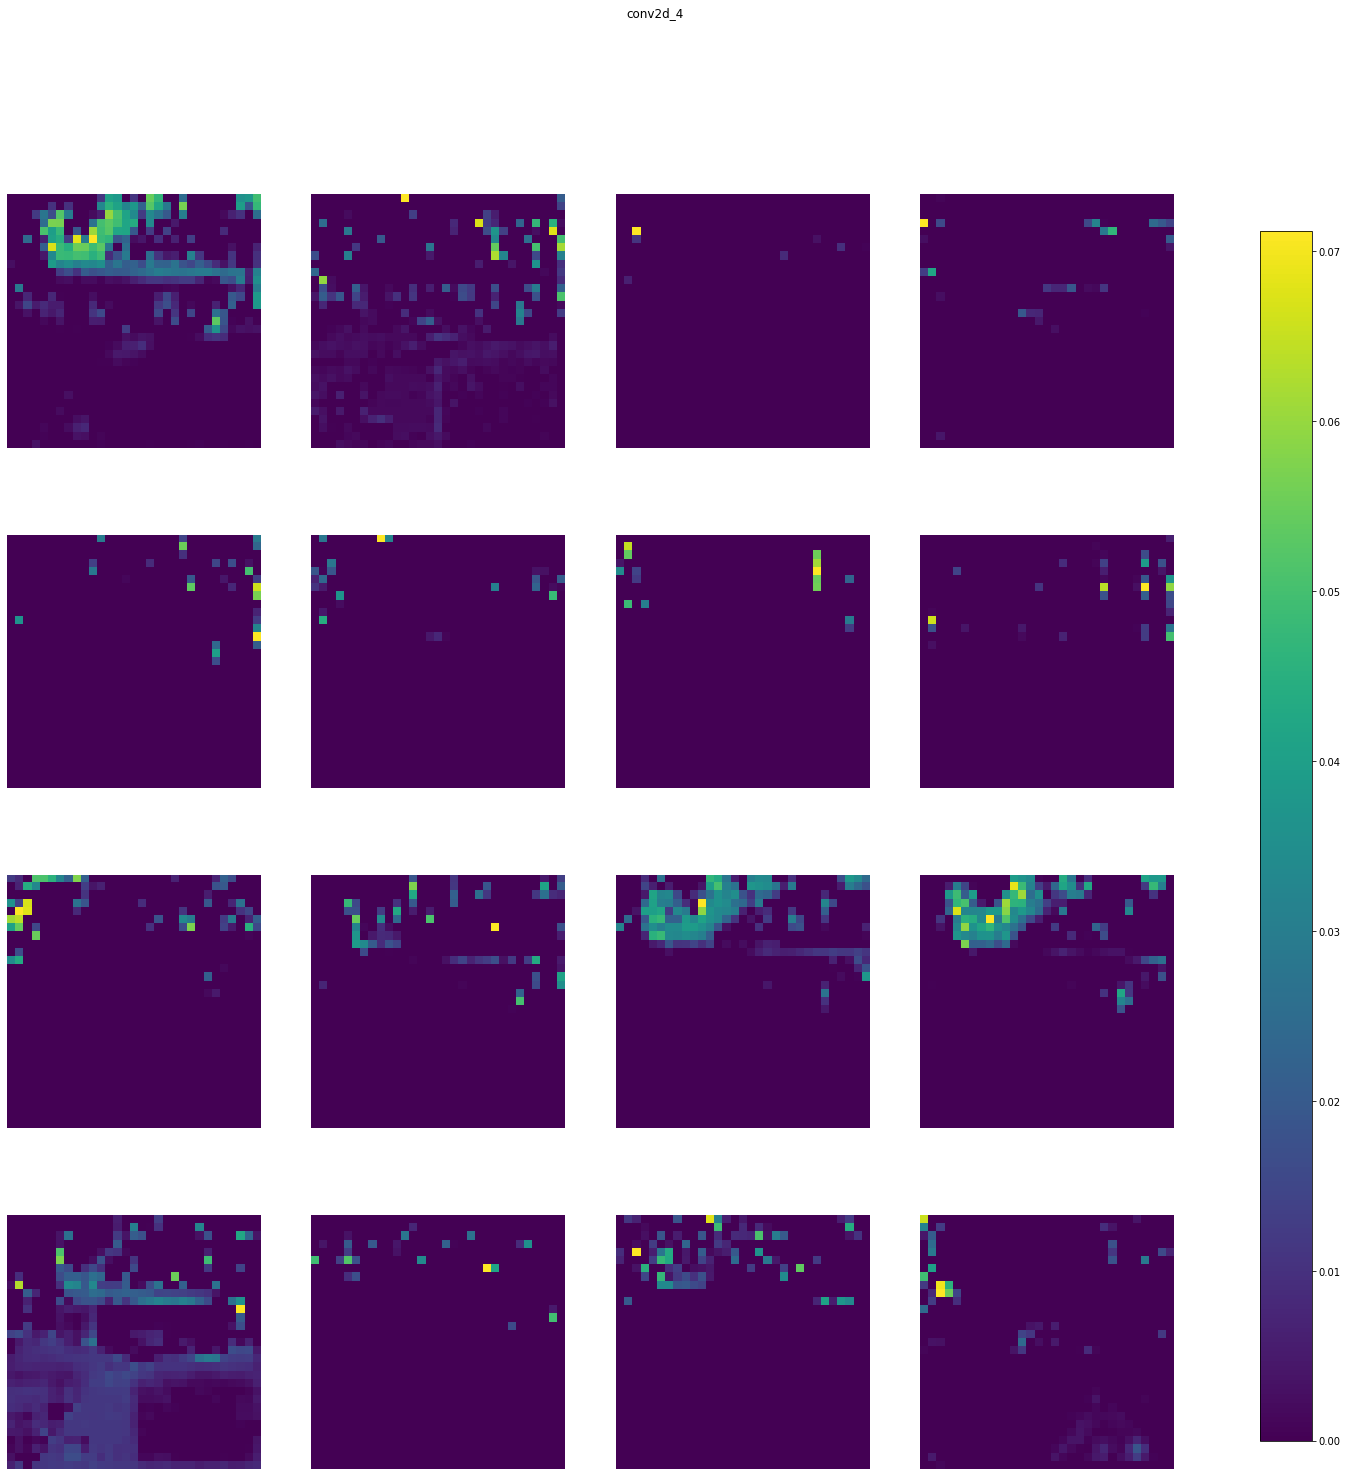

max_pooling2d_4 (1, 15, 15, 16) 


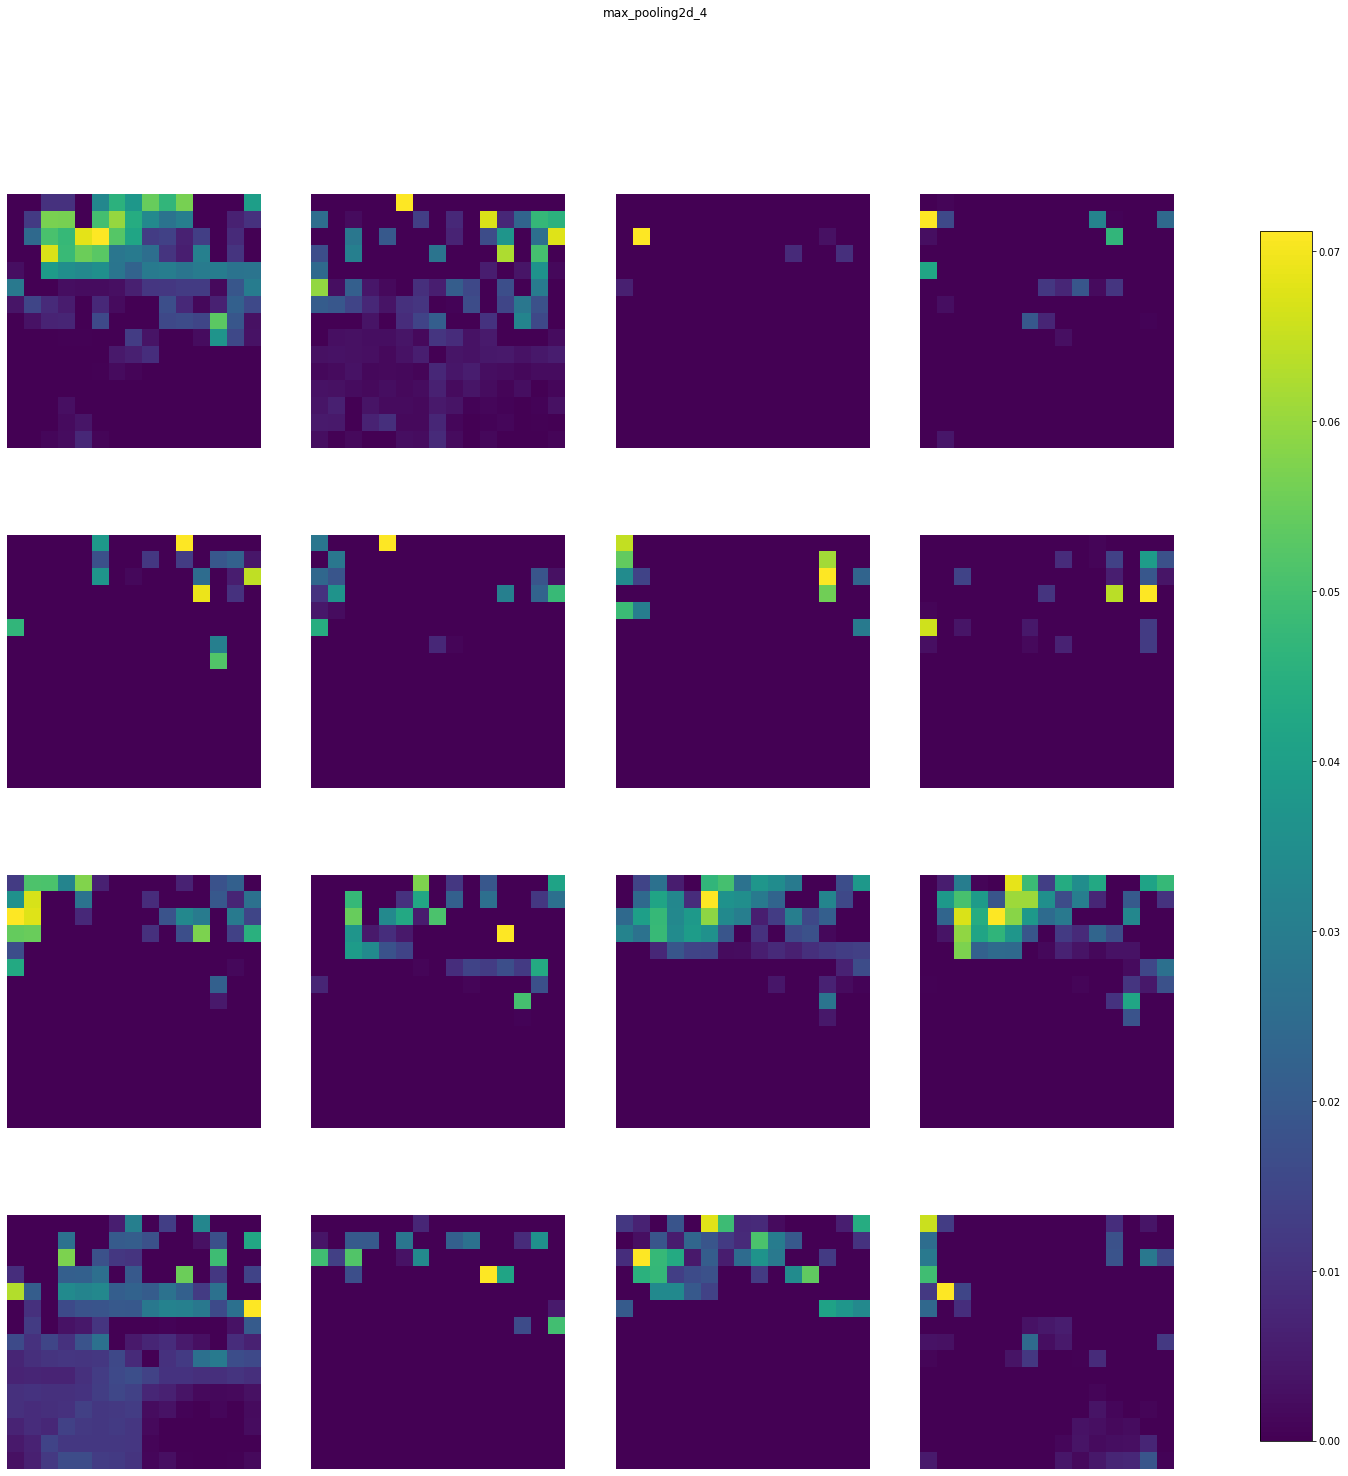

dropout_3 (1, 15, 15, 16) 


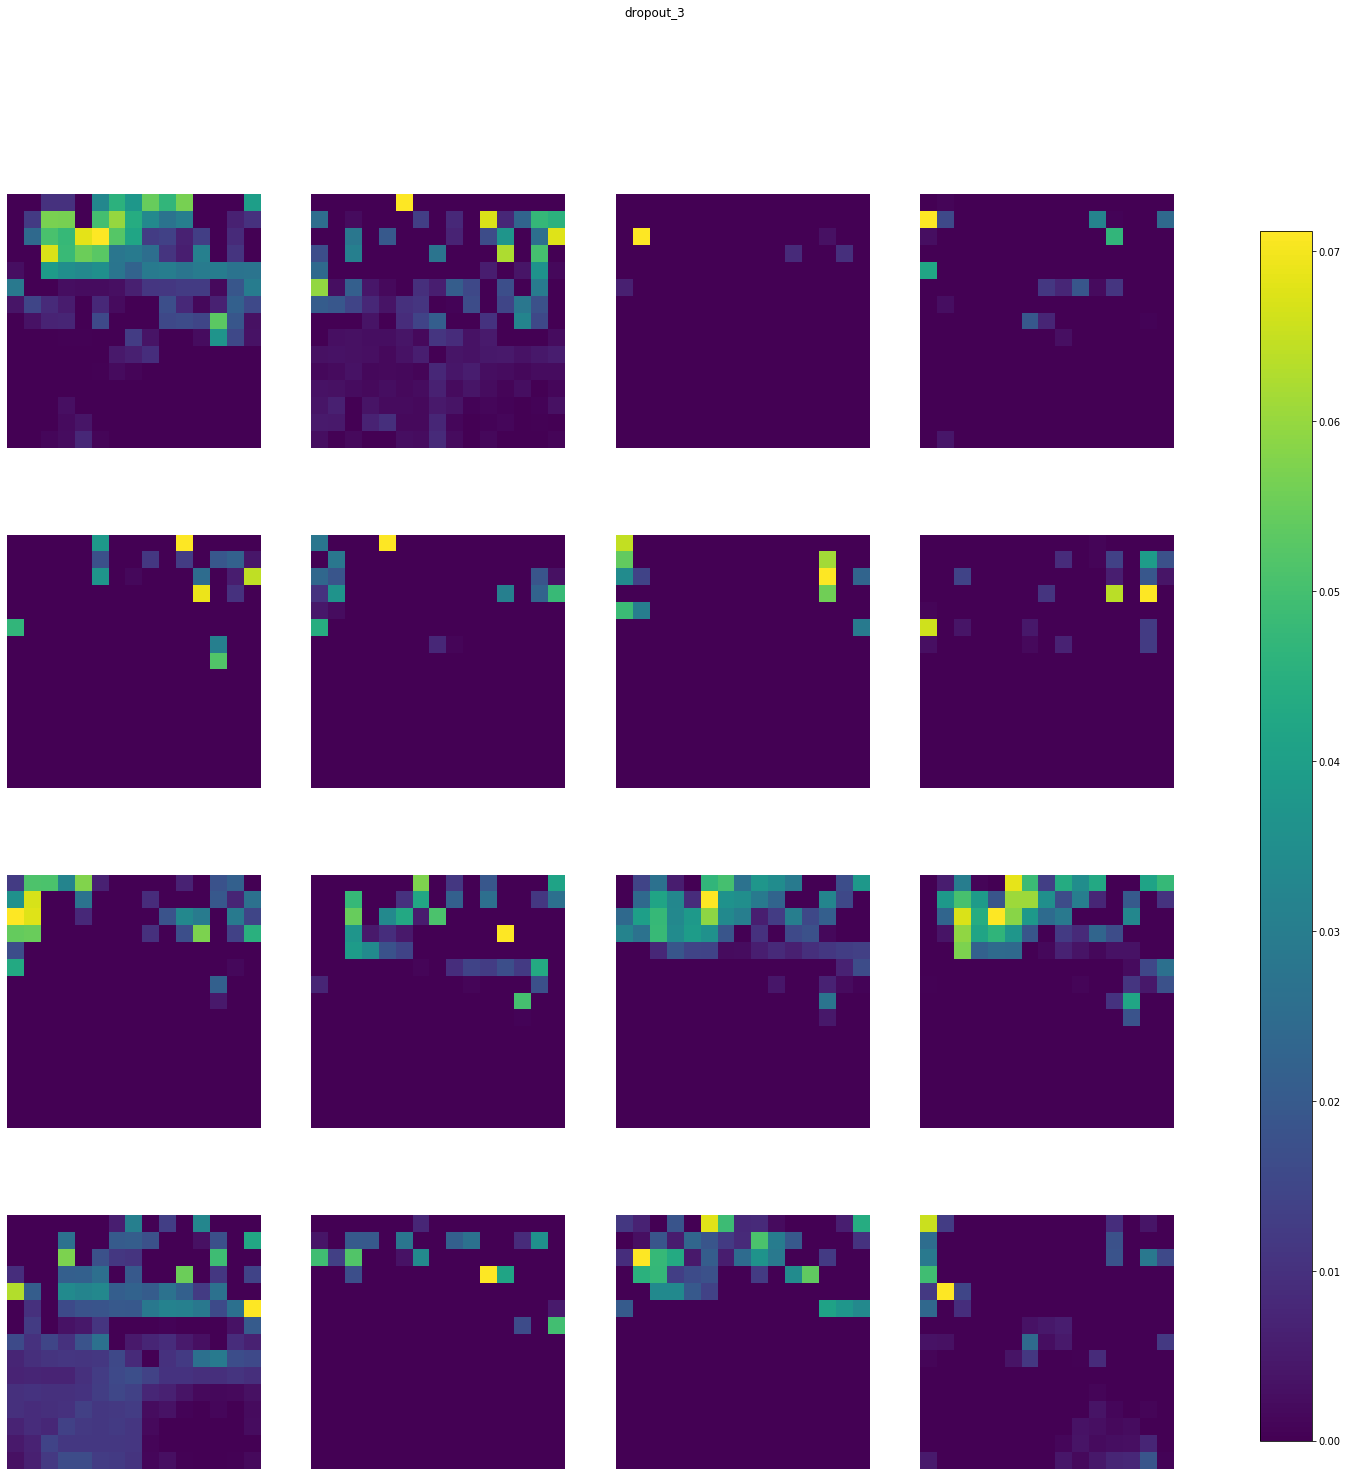

flatten (1, 3600) 


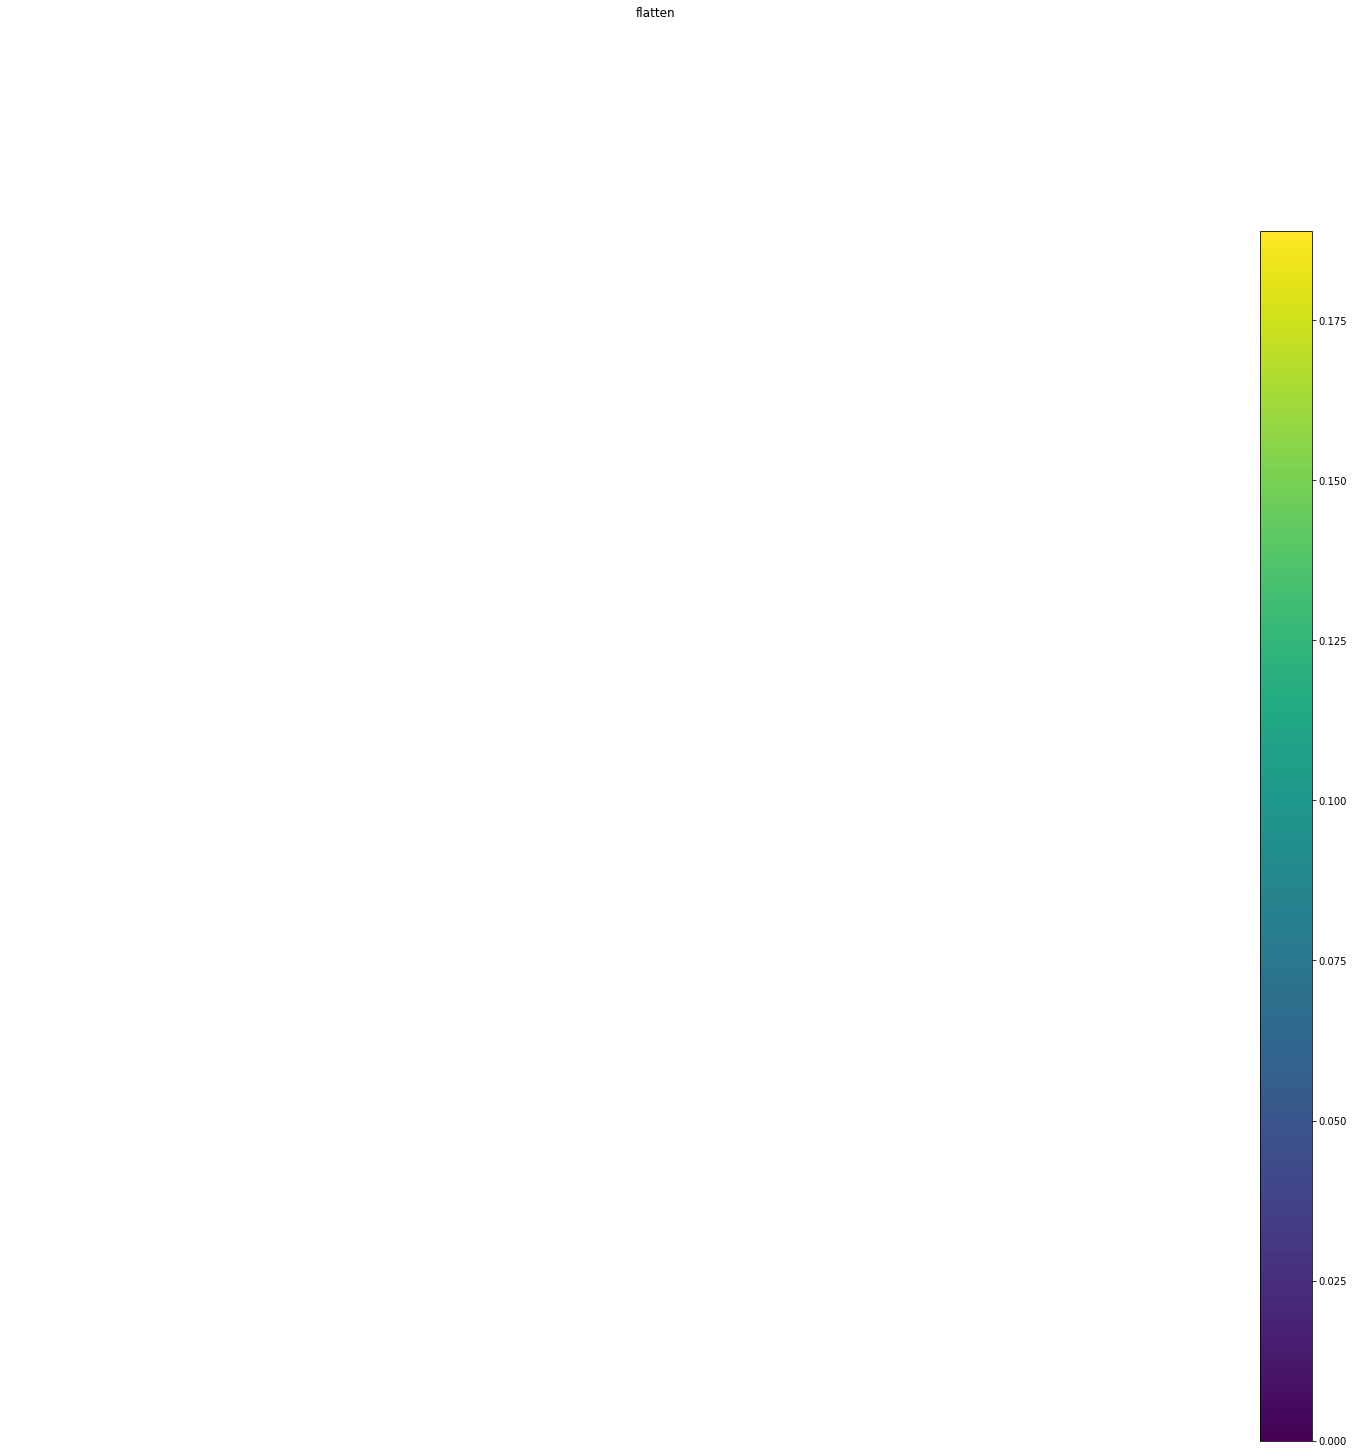

dense (1, 256) 


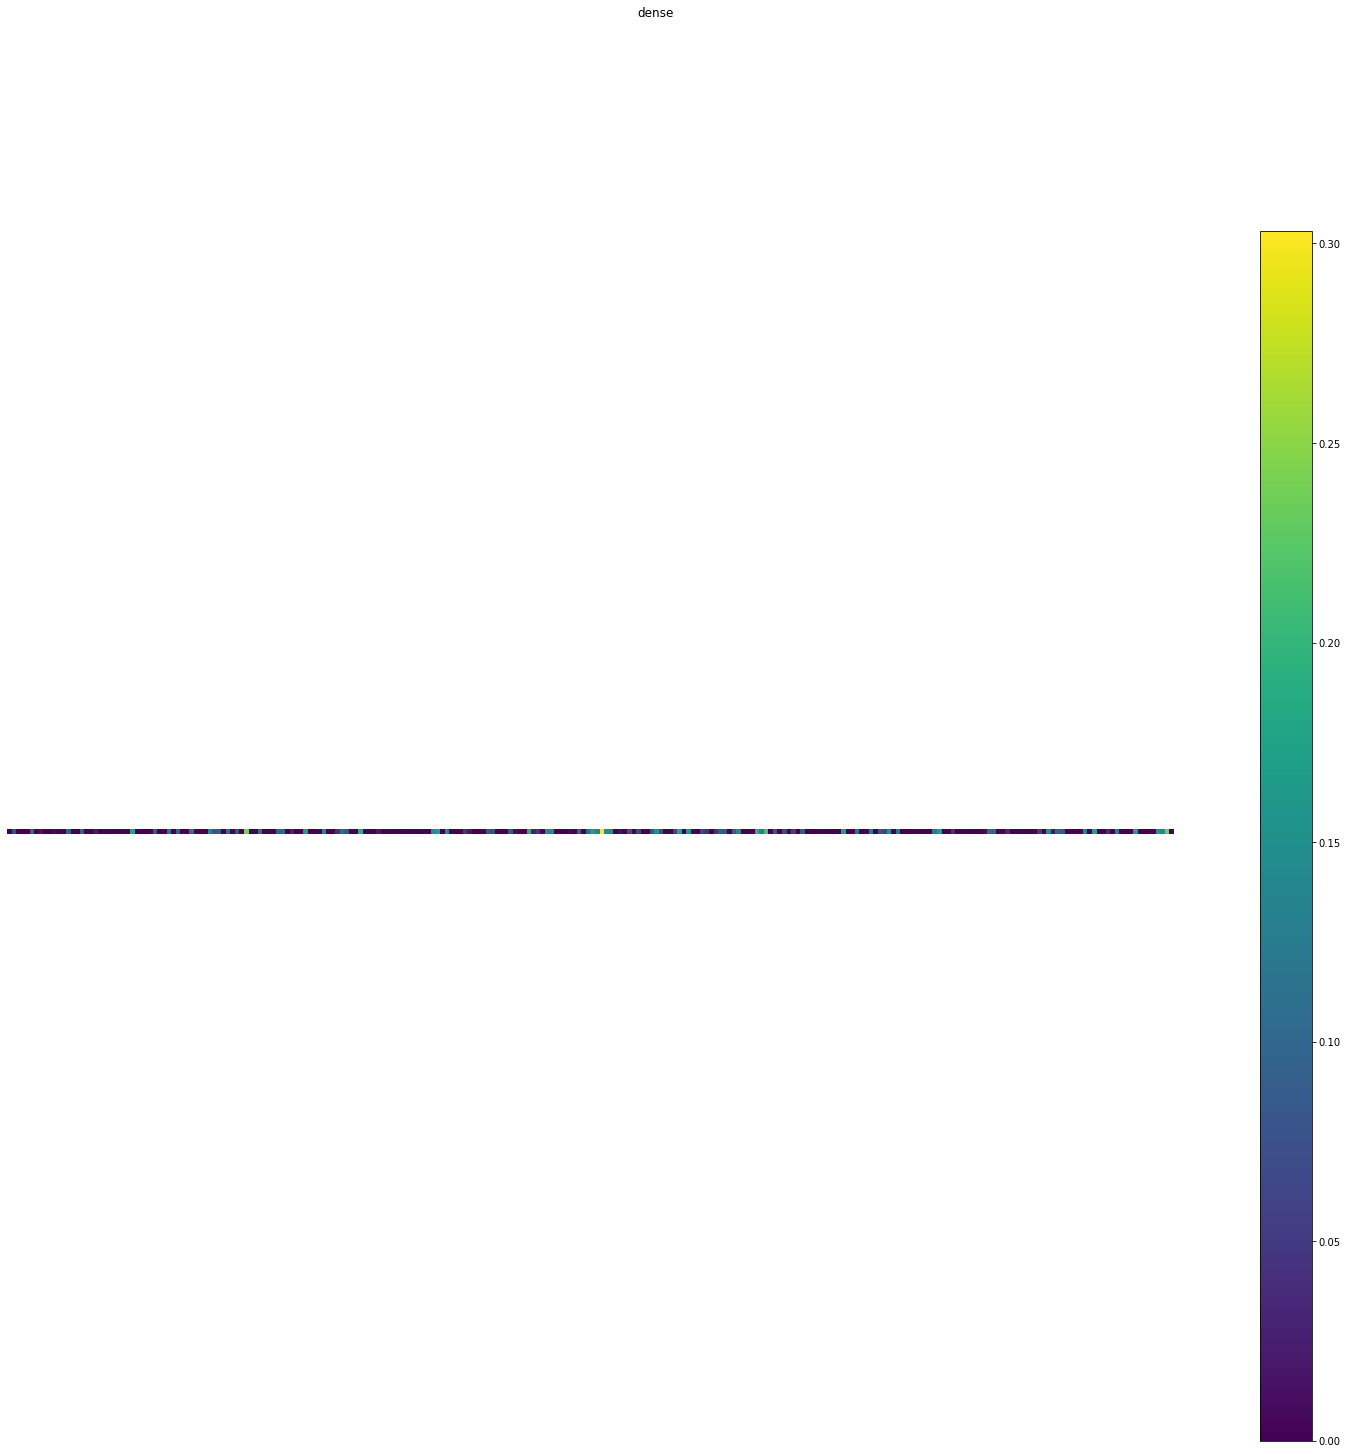

dropout_4 (1, 256) 


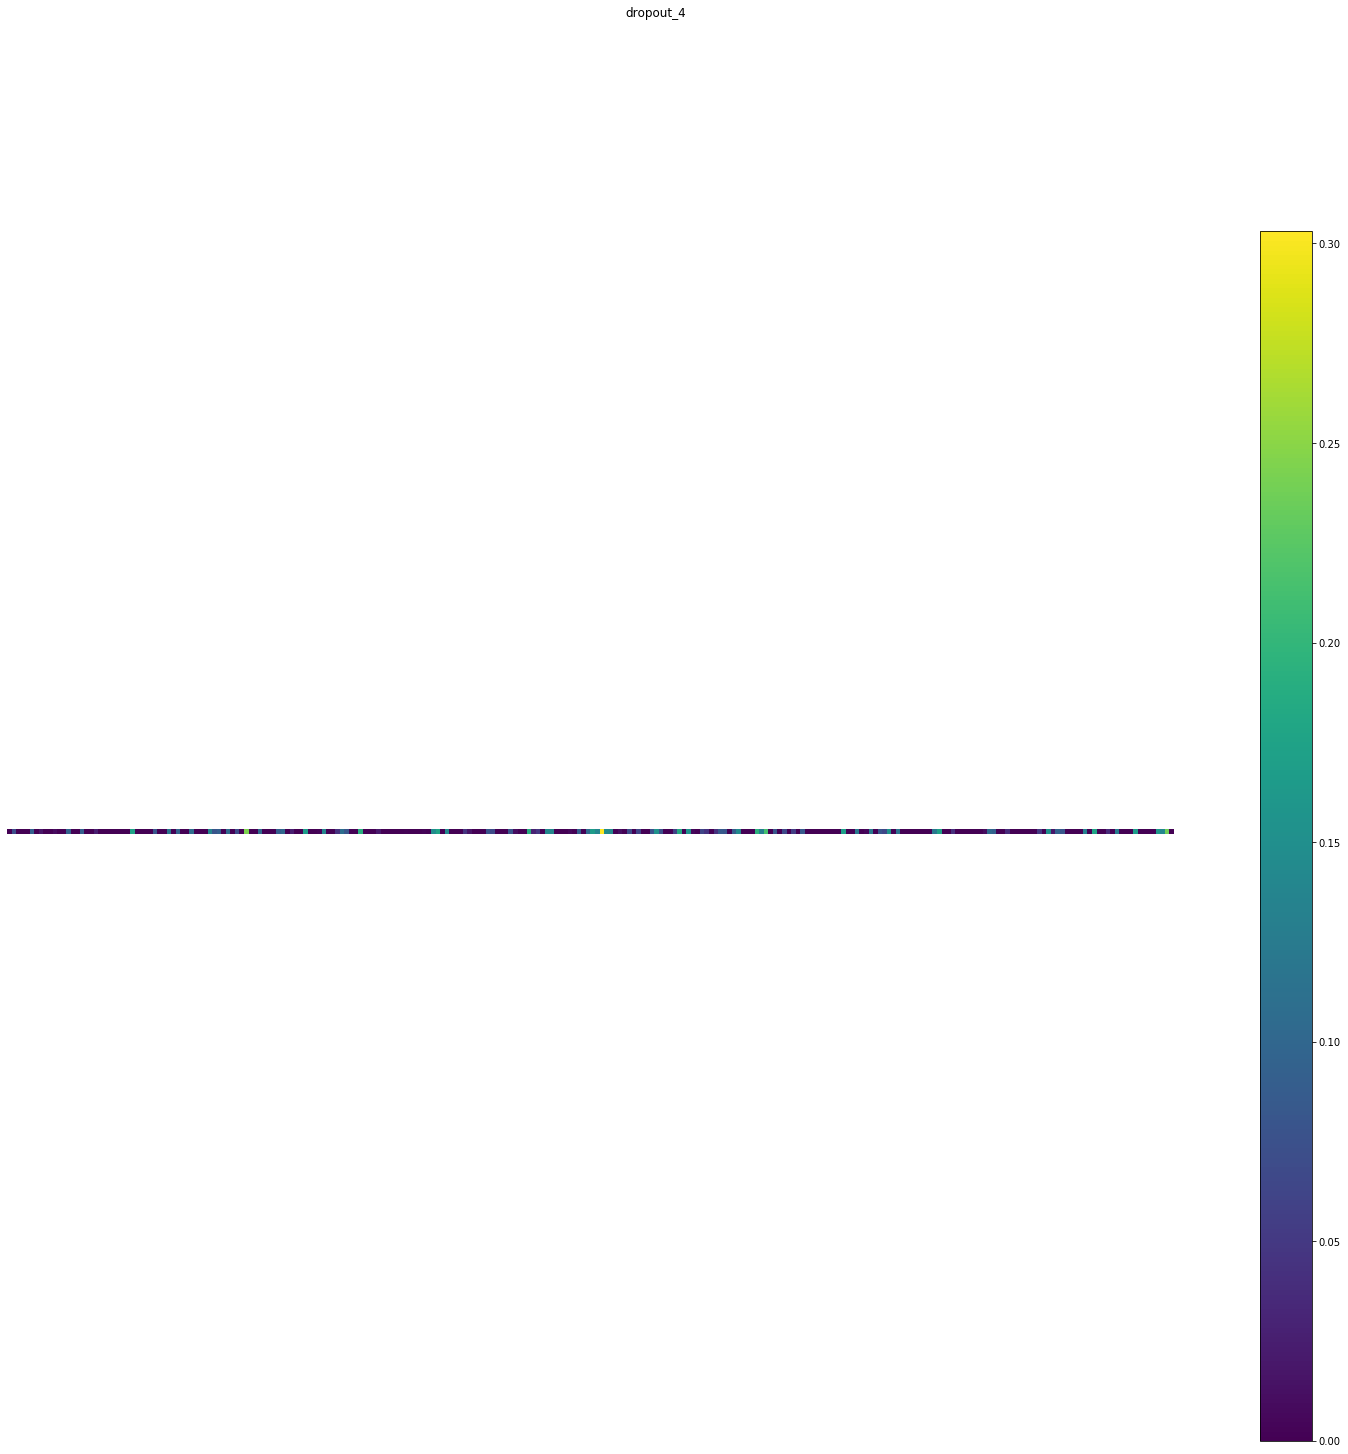

dense_1 (1, 3) 


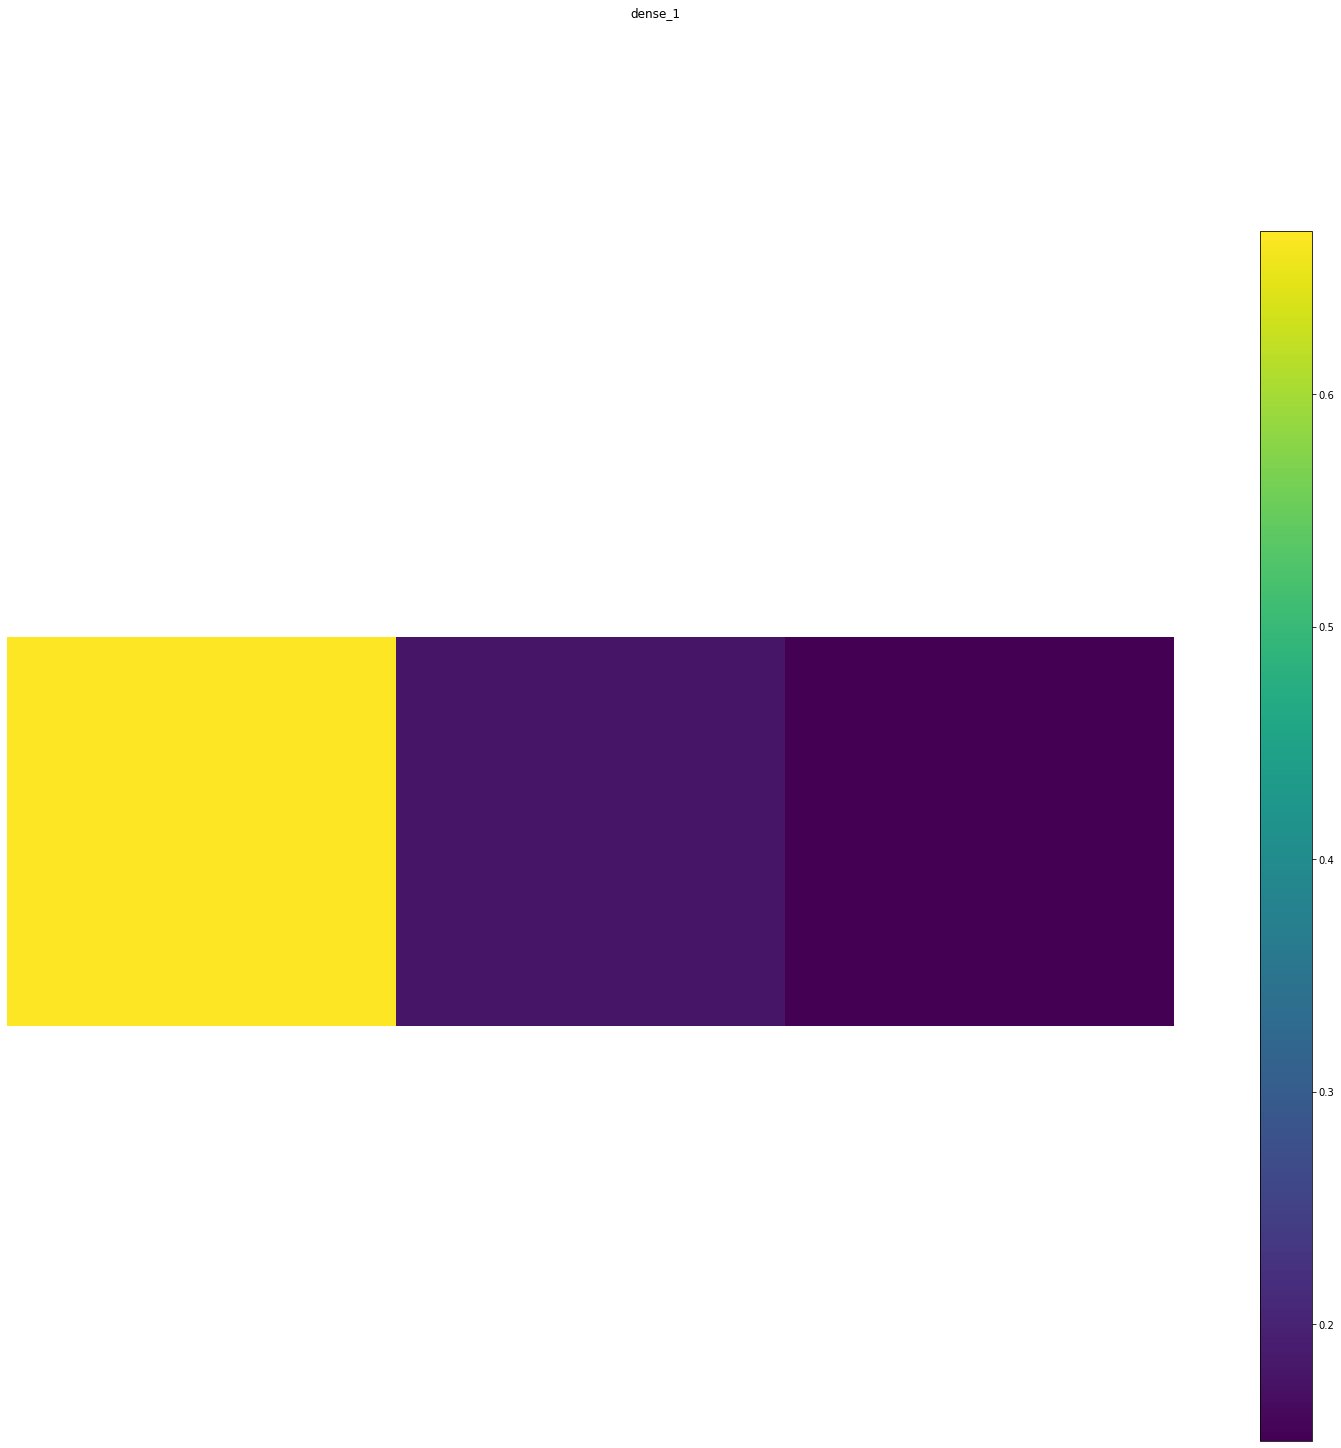

In [15]:
# =============================================
# Keract visualizations
# =============================================

keract_inputs = test_tensors[:1]
keract_targets = valid_tensors[:1]
activations = get_activations(model, keract_targets)
#display_heatmaps(activations, keract_inputs, save=False)
keract.display_activations(activations, cmap=None, save=False, directory='saved_models/viz_images', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)

